In [229]:
import pickle
import os
import bz2

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import distinctipy
import matplotlib.cm as cm
import matplotlib.colors as mcolors


from scipy import sparse
import numpy as np
import pandas as pd

import igraph as ig

from sklearn.metrics.cluster import normalized_mutual_info_score, rand_score, adjusted_rand_score, v_measure_score

from src.commdet import create_directory


In [230]:
dropbox_folder ='/Users/Cande007/Dropbox/Apps/Overleaf/2023_community_detection_on_signed_networks/'

In [231]:
# change the default options of visualization
text_color = "#404040"

custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": True, "axes.spines.bottom": True,
                "lines.linewidth": 2, "grid.color": "lightgray", "legend.frameon": True,
                 "xtick.labelcolor": text_color, "ytick.labelcolor": text_color, "xtick.color": text_color, "ytick.color": text_color,"text.color": text_color,
                "axes.labelcolor": text_color, "axes.titlecolor":text_color,"figure.dpi": 200,
                "axes.titlelocation":"center","xaxis.labellocation":"center","yaxis.labellocation":"center"}


#palette = distinctipy.get_colors(21, pastel_factor=0.8)
wong = ['#332288', '#117733','#44AA99', '#88CCEE','#DDCC77', '#CC6677','#AA4499','#882255'  ]

palette = ['#264653', '#2a9d8f', '#f4a261','#e76f51']
sns.set_theme(context='paper', style='white', palette=palette, font_scale=1.1, color_codes=True,
rc=custom_params)

colors = distinctipy.get_colors(9, pastel_factor=0.5)
text_size = 30
lw = 10
scenarios = ['u_np_s_np',  'u_np_s_p', 'u_p_s_np','u_p_s_p']

uniform_scenarios = [f'uniform/{scenario}' for scenario in scenarios]
deg_corr_scenarios = [f'deg_corr/{scenario}' for scenario in scenarios]
titles = ['U NP\nS NP',  'U NP\nS  P', 'U  P\nS NP','U  P\nS  P']
runs = 10

In [232]:
def network(mat, scenario, labels, weighted=True):
    
    if weighted:
        g = ig.Graph.Weighted_Adjacency(mat, mode = 'undirected')
        g.vs["original_id"] = list(range(g.vcount()))

        #g.simplify(multiple=True, loops=True, combine_edges=dict(weight="sum"))
    else:
        g = ig.Graph.Weighted_Adjacency(sparse.csr_matrix(mat).sign().todense(), mode = 'undirected')
        g.vs["original_id"] = list(range(g.vcount()))
    
    g.vs["labels"] = labels
    #g.vs['color'] = ['#42BFDD' if w > 0 else '#F24333' for w in labels]
    g = g.components().giant()

    return g

In [277]:
def get_folder(dataset, synth, scenario, method,weighted = True, year = 0):
    folder = f'./results/{dataset}/synth/{scenario}/{method}/' if synth else f'./results/{dataset}/real-data/{method}/'
    if year >0:
        folder = f'./results/{dataset}/synth/{year}/{scenario}/{method}/' if synth else f'./results/{dataset}/real-data/{year}/{method}/'
    folder = folder + f'weighted/' if weighted else folder + f'unweighted/'
        #create_directory(folder)
    return folder


In [299]:
def rand_score_df(method, dataset, mats, labels, synth, scenarios,titles=titles, metrics = 'rand', year = 0, weight = True):
    if method == 'spinglass':
        gammas = [0.5, 1, 2]
        lambdas = [0.5, 1, 2]
        dfs = []
        for i in range(len(mats)):
            mat = mats[i]
            label = labels[i]
            scenario = scenarios[i]
            title = titles[i]
            if isinstance(year, list):
                y = year[i]
            g = network(mat, scenario, label)
            for weight in [True,False]:
                df = pd.DataFrame(columns = gammas, index = lambdas)
                for gamma in gammas:
                    for lambd in lambdas:
                        folder = get_folder(dataset,synth, scenario,'spinglass',weighted=weight,year=y)
            
                        with open(folder+f'gamma_{gamma}_lambda_{lambd}_run_0.pickle', 'rb') as f:
                            spinglass = pickle.load(f)
                        
                        if metrics == 'rand':
                            df[gamma][lambd] = rand_score(g.vs['labels'], spinglass)
                        elif metrics == 'ari':
                            df[gamma][lambd] = adjusted_rand_score(g.vs['labels'], spinglass)
                        elif metrics == 'nmi':
                            df[gamma][lambd] = normalized_mutual_info_score(g.vs['labels'], spinglass)
                        elif metrics == 'v_score':
                            df[gamma][lambd] = v_measure_score(g.vs['labels'], spinglass)
                dfs.append(df)
        return dfs
    
    elif method == 'sponge':
        ks = [1,2,3,4,5,6,7,8,9,10]
        df = pd.DataFrame(columns = ks, index = titles)
        df_std = pd.DataFrame(columns = ks, index = titles)
        for i in range(len(mats)):
            label = labels[i]
            scenario = scenarios[i]
            title = titles[i]
            if isinstance(year, list):
                y = year[i]
            g = network(mats[i], scenario, label)
            folder = get_folder(dataset,synth, scenario,'sponge',weighted=weight,year=y)
            
            for k in ks:
                rand = []
                for run in range(runs):
                    with open(folder+f'{k}_run_{run}.pickle', 'rb') as f:
                        sponge = pickle.load(f)
                    if metrics == 'rand':
                        rand.append(rand_score(label, sponge))
                    elif metrics == 'ari':
                        rand.append(adjusted_rand_score(label, sponge))
                    elif metrics == 'nmi':
                        rand.append(normalized_mutual_info_score(label, sponge))
                    elif metrics == 'v_score':
                        rand.append(v_measure_score(label, sponge))
                            
                df[k][title] = np.mean(rand)
                df_std[k][title] = np.std(rand)
        return df, df_std

In [265]:
def load_data(path):
    path_adj = path+'/adj/'
    path_labels = path+'/label/'
    file_names = ['u_np_s_np.pkl',  'u_np_s_p.pkl', 'u_p_s_np.pkl','u_p_s_p.pkl']
    
    mats = [pickle.load(open(path_adj + f, 'rb')) for f in file_names]
    labels = [pickle.load(open(path_labels + f, 'rb')) for f in file_names]
    return mats, labels

def plot_spinglass_synth(ax, dfs, lambdas, gammas, titles, text_size, xticks = True):
    x = 0
    ticks = []
    for lambd in lambdas:
        for gamma in gammas:
            delta = 0
            for i, df in enumerate(dfs):
                ax.scatter(x+delta, df.at[gamma, lambd], s = 500, marker = 'h')
                delta += 0.15
            ticks.append(f'$\gamma^+$ = {gamma:.1f}\n$\gamma^-$ = {lambd:.1f}')
            ax.axvline(x+0.7, ls='--', alpha =0.2)
            x +=1
    if xticks:
        ax.set_xticks([i+0.2 for i in range(x)],ticks, fontsize=text_size, rotation =90)
    else:
        ax.set_xticks([])
    ax.tick_params(axis='both', labelsize=text_size)
    patchList = [mpatches.Patch(color=palette[key], label=title) for key, title in enumerate(titles)]
    plt.legend(handles=patchList, bbox_to_anchor=(1, 1), fontsize = text_size)

def plot_sponge_synth(ax, df, df_std, text_size, titles,  xticks = True):
    x = df.T.index.tolist()
    mean = df.T.values.tolist()
    std = df_std.T.values.tolist()
    ax.plot(x, [row[0] for row in mean], label = df.T.columns[0],marker='s', markersize=15, linestyle='-', linewidth=lw, alpha =0.8)
    ax.plot(x, [row[1:] for row in mean], label = df.T.columns[1:],marker='o', markersize=5, linestyle='-', linewidth=lw, alpha =0.8)
    for m, s, in zip(np.array(mean).T, np.array(std).T):
        m = np.array(m)
        s = np.array(s)
        ax.fill_between(x, m-s, m+s, alpha=0.4, interpolate=True)
    ax.scatter(x = 1, y = 1, s = 70, marker = 'x', c = '#219ebc', zorder=3, label = 'exp. value\nusers pol.')
    ax.scatter(x = 2, y = 1, s = 70, marker = 'x', c = '#bc6c25', zorder=3, label = 'exp. value\nusers not pol.')
    
    if xticks:
        ax.set_xlabel('no. of clusters', fontsize =text_size)
        ax.set_xticks(x, x, fontsize=text_size)
    else:
        ax.set_xticks([])
    ax.tick_params(axis='both', labelsize=text_size)
    patchList = [mpatches.Patch(color=palette[key], label=title) for key, title in enumerate(titles)]
    plt.legend(handles=patchList, bbox_to_anchor=(1, 1), fontsize = text_size)


def save_plot(path, filename, dropbox_folder=dropbox_folder):
    create_directory(path)
    create_directory(path.replace('./', f'{dropbox_folder}'))
    plt.savefig(path+filename)
    plt.savefig(path.replace('./', f'{dropbox_folder}')+filename)


In [236]:
measures = ['rand', 'ari', 'nmi', 'v_score']
measures_labels = ['RI', 'ARI', 'NMI', 'v-score']

# Meneame

## Synthetic networks

### Spinglass and SPONGE

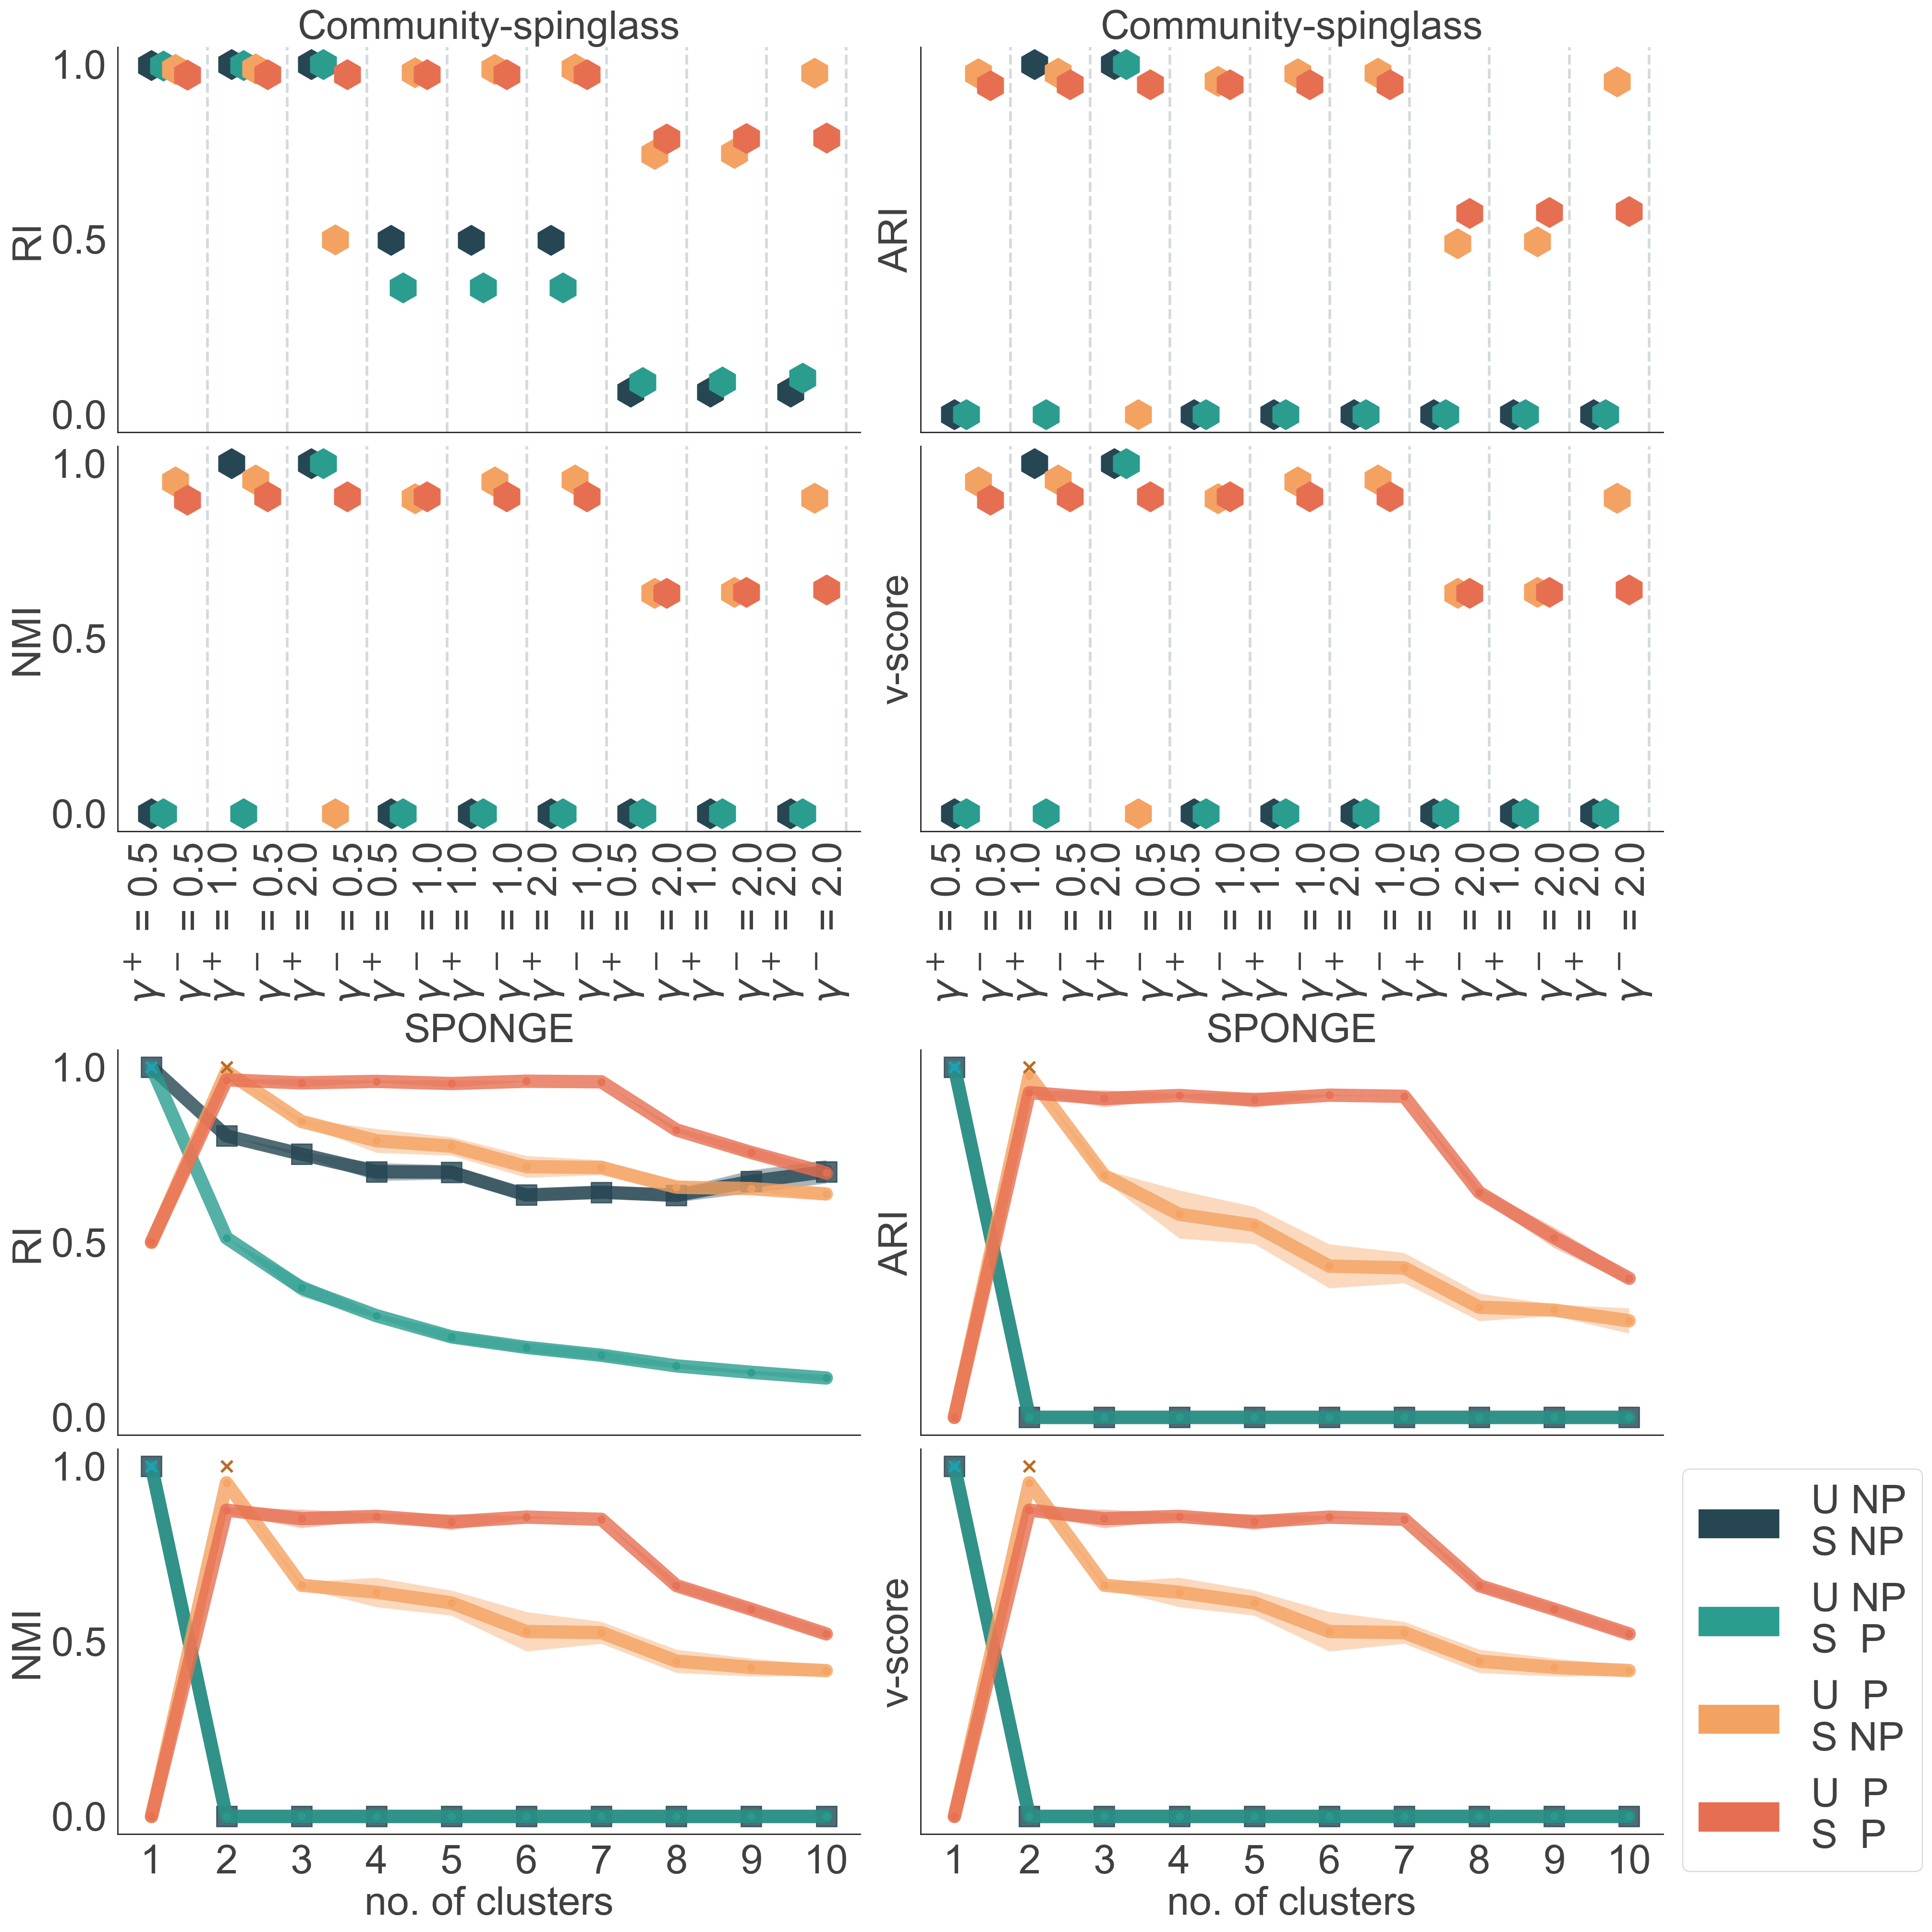

In [237]:
gammas = [0.5, 1, 2]
lambdas = [0.5, 1, 2]

mats, labels = load_data('./data/meneame/synth/uniform/')
fig, axs = plt.subplots(4, 2, figsize = (20,20),dpi =200, sharey=True, constrained_layout=True)


j = 0
for m, ax in zip(measures+measures, axs.ravel()):
    if j < 4:
        dfs = rand_score_df(method='spinglass',dataset='meneame',mats= mats, labels=labels, scenarios=uniform_scenarios,synth=True, metrics=m)

        if j == 0 or j == 1:  
            ax.set_title(f'Community-spinglass', size = text_size)
            plot_spinglass_synth(ax, dfs[::2], lambdas, gammas, titles, text_size, xticks = False)
        else:
            plot_spinglass_synth(ax, dfs[::2], lambdas, gammas, titles, text_size, xticks = True)
        ax.set_ylabel((measures_labels+measures_labels)[j], size =text_size)
        j+=1
    else:
        df, df_std = rand_score_df(method='sponge',dataset='meneame',mats= mats, scenarios=uniform_scenarios,labels=labels,synth=True, metrics=m)
        if j == 4 or j == 5:
            ax.set_title(f'SPONGE', size = text_size)
            plot_sponge_synth(ax, df, df_std, text_size, titles, xticks=False)
        else:
            plot_sponge_synth(ax, df, df_std, text_size, titles, xticks=True)
        ax.set_ylabel((measures_labels+measures_labels)[j], fontsize =text_size)
        j+=1


save_plot(path = './plots/uniform/', filename = 'metrics_comparison.pdf')
plt.show()

### SBM -deg. corr.

In [238]:
from src.signet import *

mats, labels = load_data('./data/meneame/synth/uniform/')

dfs = []

for w in ['weighted', 'unweighted']:
    df = pd.DataFrame(columns = ['rand', 'ari', 'nmi', 'v_score'], index = titles)
    for i in range(len(mats)):
        label = labels[i]
        scenario = uniform_scenarios[i]
        title = titles[i]
        mat = mats[i]
        graph_build = SignedNetwork()
        g = graph_build.graph_construction(repre=mat, repre_type='adj', is_directed=check_if_directed(mat))
        folder = get_folder('meneame',synth = True,scenario= scenario,method='sbm',weighted=True,year=0)
        with open(f'{folder}sbm_deg_corr.pkl', 'rb') as f:
            sbm = pickle.load(f)
            print(sbm)
        g.vp['membership'] = g.new_vertex_property(value_type="double", vals=sbm)
        g.vp['labels'] = g.new_vertex_property(value_type="double", vals=label)

        df['rand'][title] = rand_score(list(g.vp['labels']), list(g.vp['membership']))
        df['ari'][title] = adjusted_rand_score(list(g.vp['labels']), list(g.vp['membership']))
        df['nmi'][title] = normalized_mutual_info_score(list(g.vp['labels']), list(g.vp['membership']))
        df['v_score'][title] = v_measure_score(list(g.vp['labels']), list(g.vp['membership']))
    dfs.append(df)

print(dfs)


# Initialize an empty dictionary to store the counts
counts_dict = {}

for scenario in uniform_scenarios:
    folder = get_folder('meneame',synth = True,scenario= scenario,method='sbm',weighted=True,year=0)
    with open(f'{folder}sbm_deg_corr.pkl', 'rb') as f:
        sbm = pickle.load(f)
    labels, counts = np.unique(sbm, return_counts=True)

    # Create a dictionary for the current combination of gamma and lambd
    current_counts = dict(zip(labels, counts))

    # Add the current counts to the overall counts dictionary
    counts_dict[scenario] = current_counts

# Convert the counts dictionary to a DataFrame
df = pd.DataFrame(counts_dict).T

# Set the column names
df.columns = [f'comm. {label}' for label in df.columns]



# Replace NaN values with zeros
df = df.fillna(0)

df = df.astype(int)

[0, 1, 2, 3, 4, 5, 6, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 14, 30, 31, 19, 32, 33, 29, 10, 30, 34, 35, 11, 19, 36, 37, 33, 7, 24, 0, 38, 39, 40, 20, 25, 20, 3, 19, 35, 41, 42, 43, 44, 43, 7, 45, 41, 46, 47, 46, 13, 44, 48, 49, 50, 8, 51, 23, 46, 52, 9, 53, 50, 54, 55, 56, 24, 57, 55, 58, 59, 60, 32, 50, 39, 61, 18, 62, 63, 64, 17, 26, 5, 22, 65, 57, 40, 21, 62, 66, 45, 19, 43, 65, 24, 10, 0, 67, 32, 9, 68, 5, 20, 15, 63, 27, 19, 17, 69, 28, 70, 37, 26, 20, 10, 62, 59, 71, 40, 72, 28, 6, 27, 31, 73, 43, 74, 2, 73, 62, 75, 25, 9, 58, 15, 76, 34, 21, 6, 61, 18, 9, 15, 5, 66, 6, 61, 5, 30, 37, 77, 78, 55, 79, 8, 40, 44, 29, 63, 23, 35, 58, 20, 51, 50, 66, 80, 15, 73, 81, 82, 43, 2, 62, 2, 69, 83, 18, 51, 26, 82, 42, 84, 85, 86, 42, 19, 73, 87, 55, 22, 76, 14, 38, 10, 88, 57, 55, 72, 35, 26, 89, 28, 86, 53, 9, 71, 37, 58, 74, 20, 90, 30, 76, 35, 91, 9, 71, 8, 15, 56, 76, 50, 41, 92, 3, 21, 24, 70, 67, 85, 65, 54, 93, 65, 7, 54, 73, 

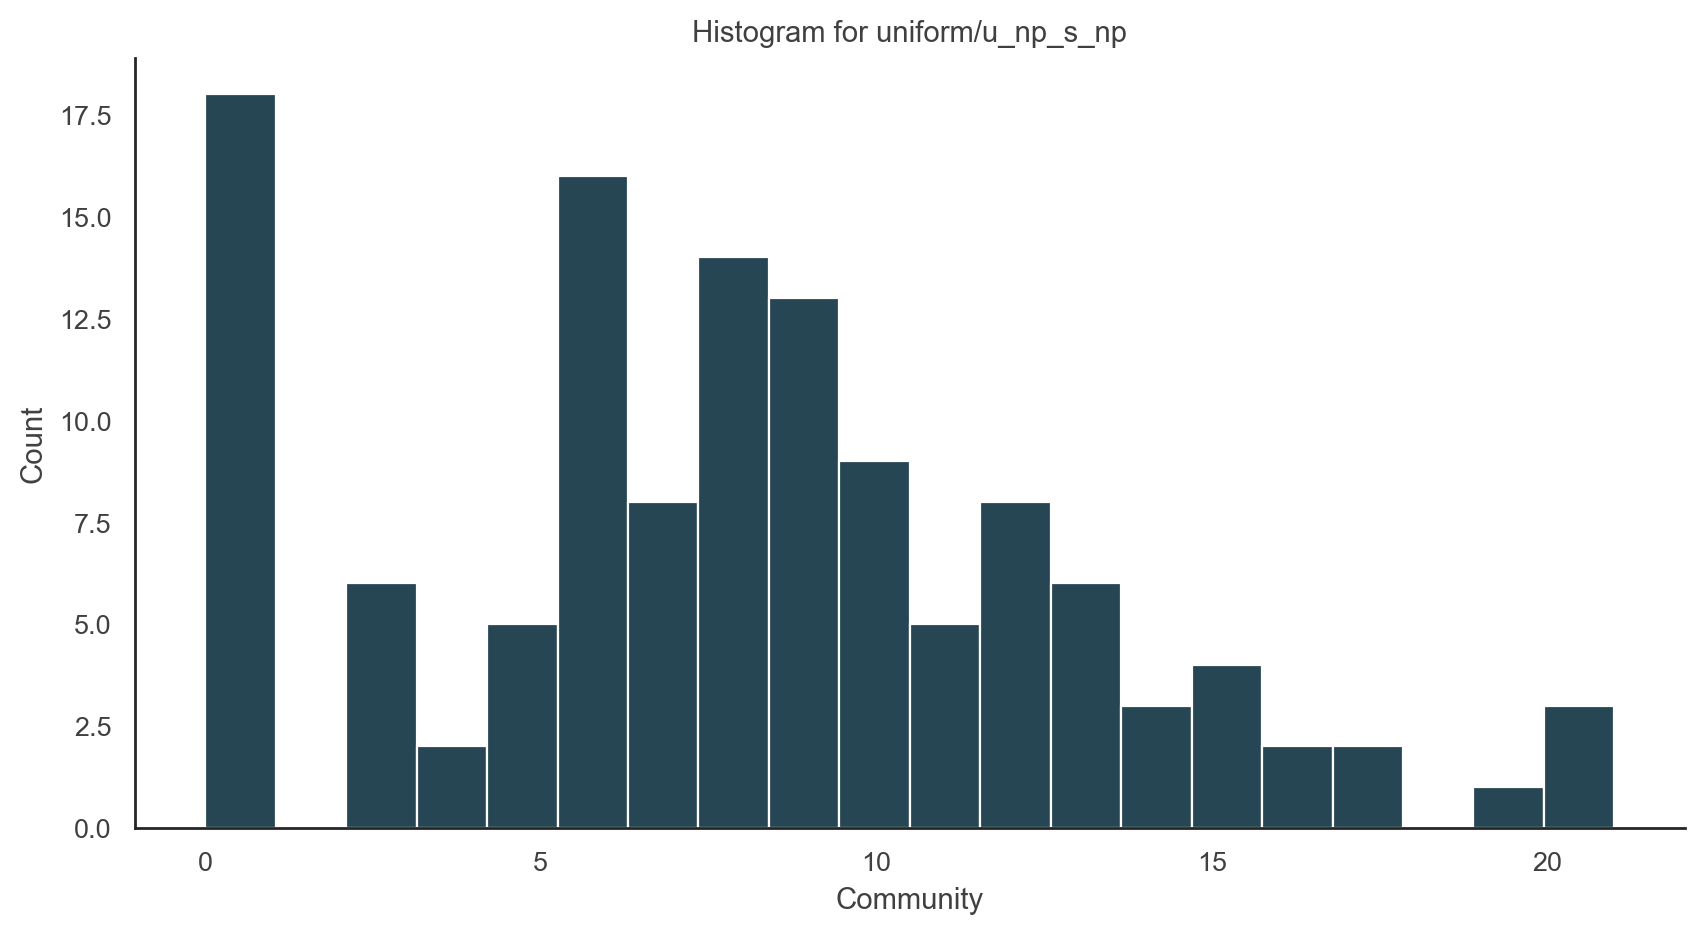

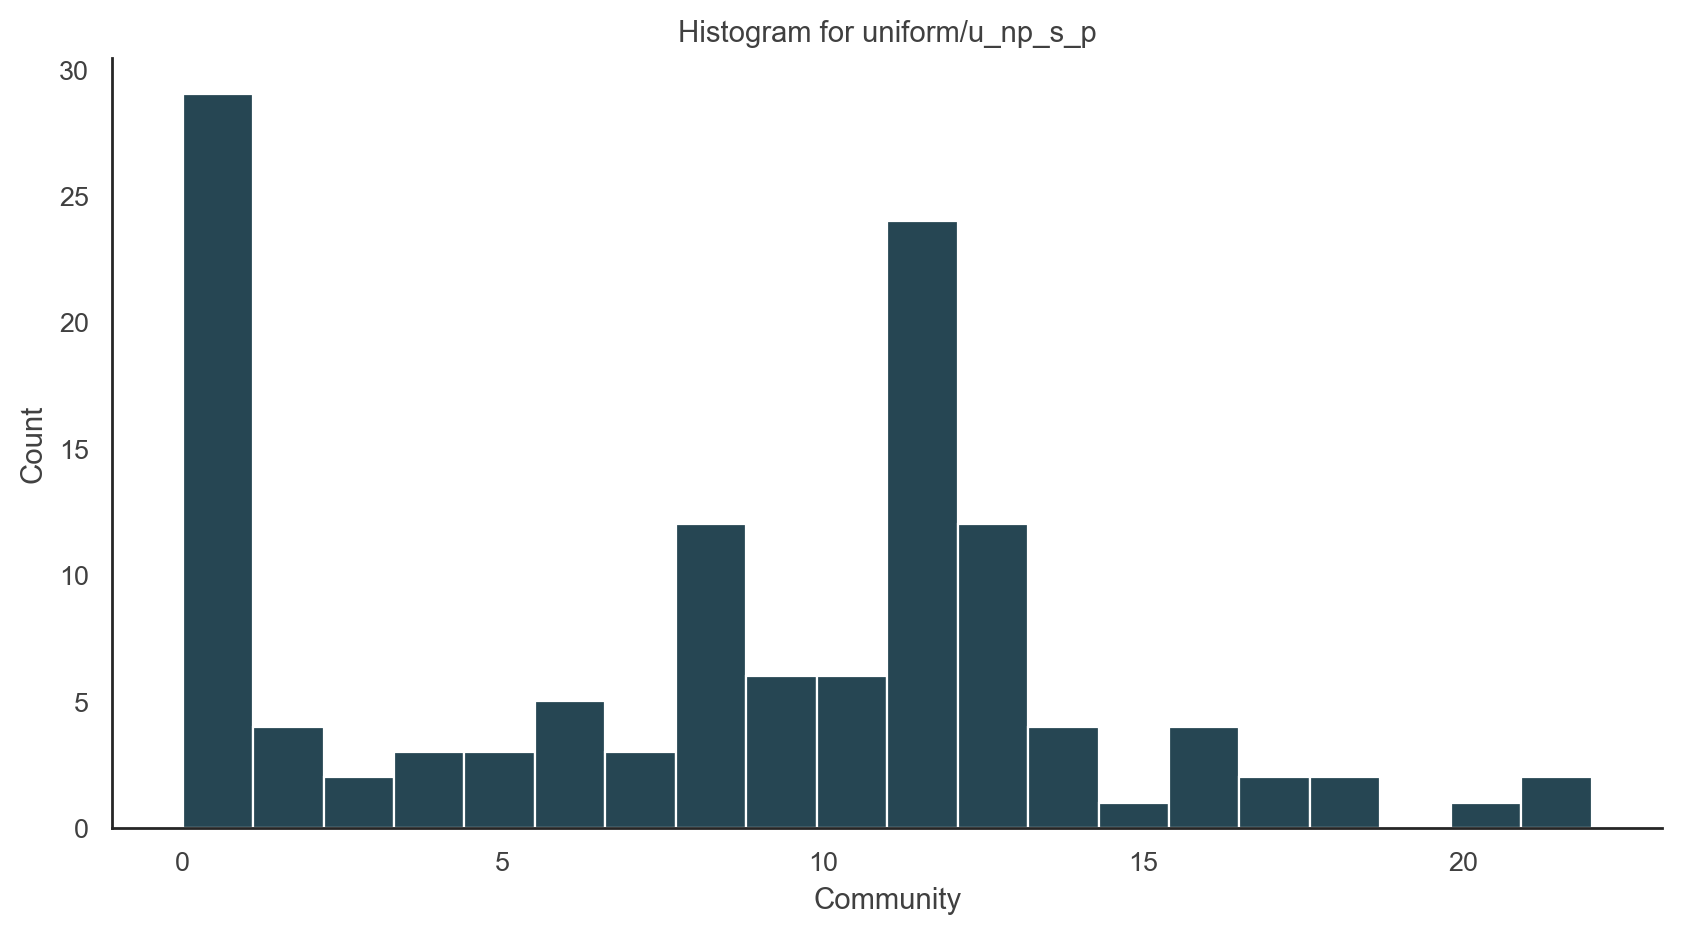

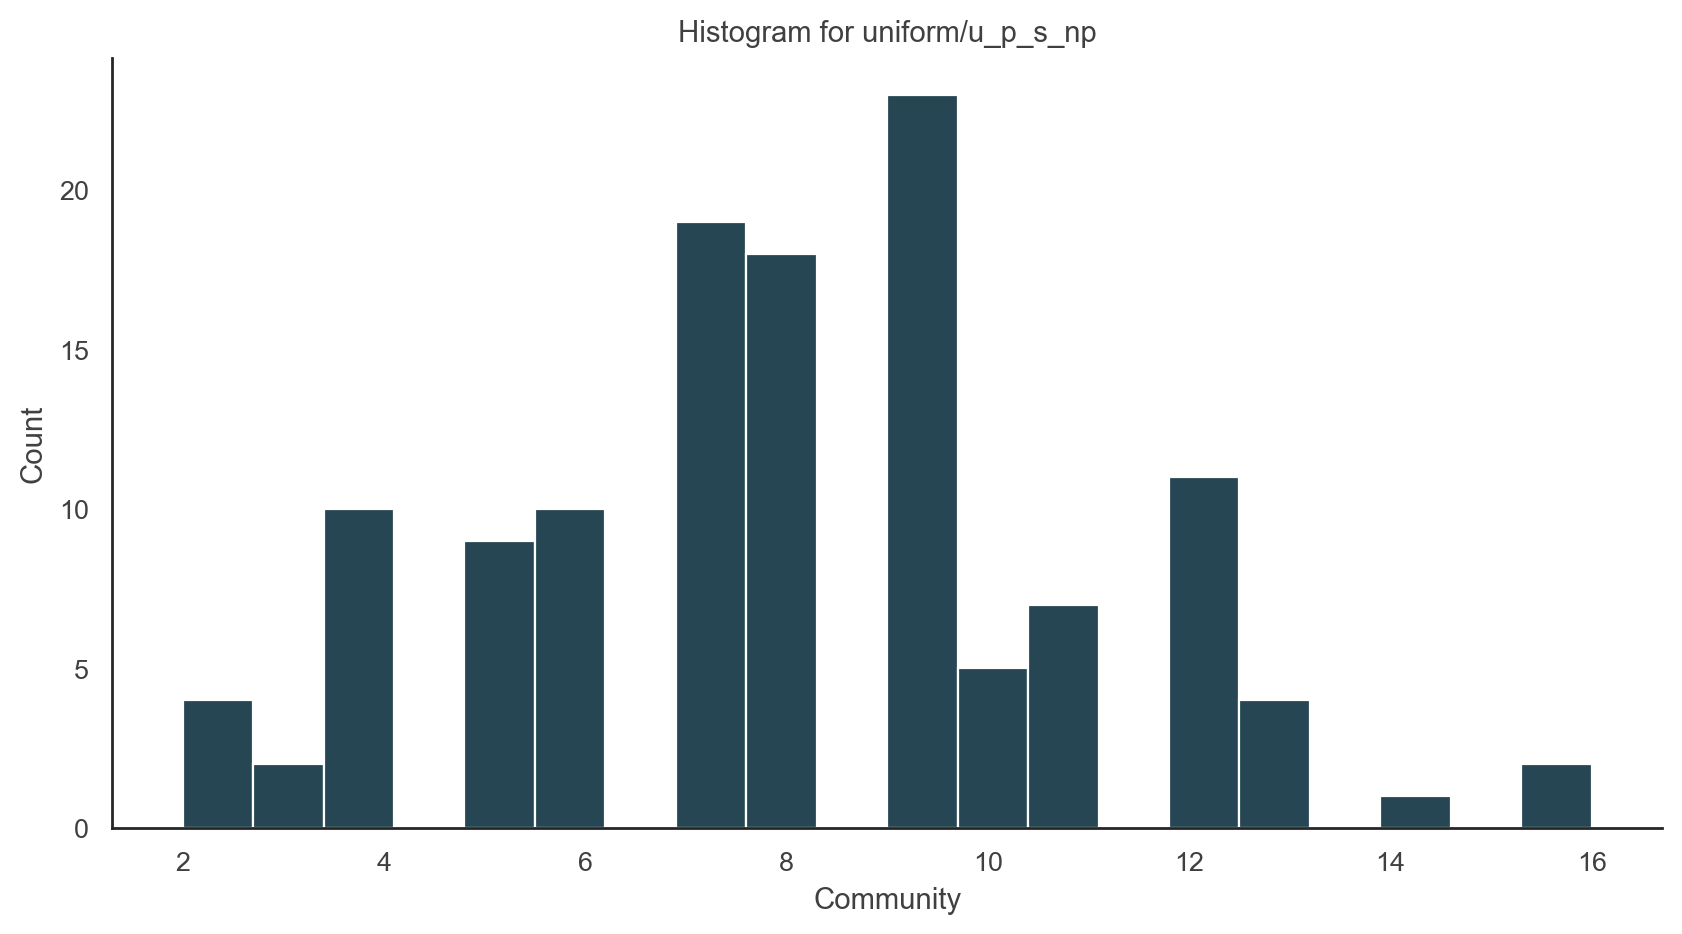

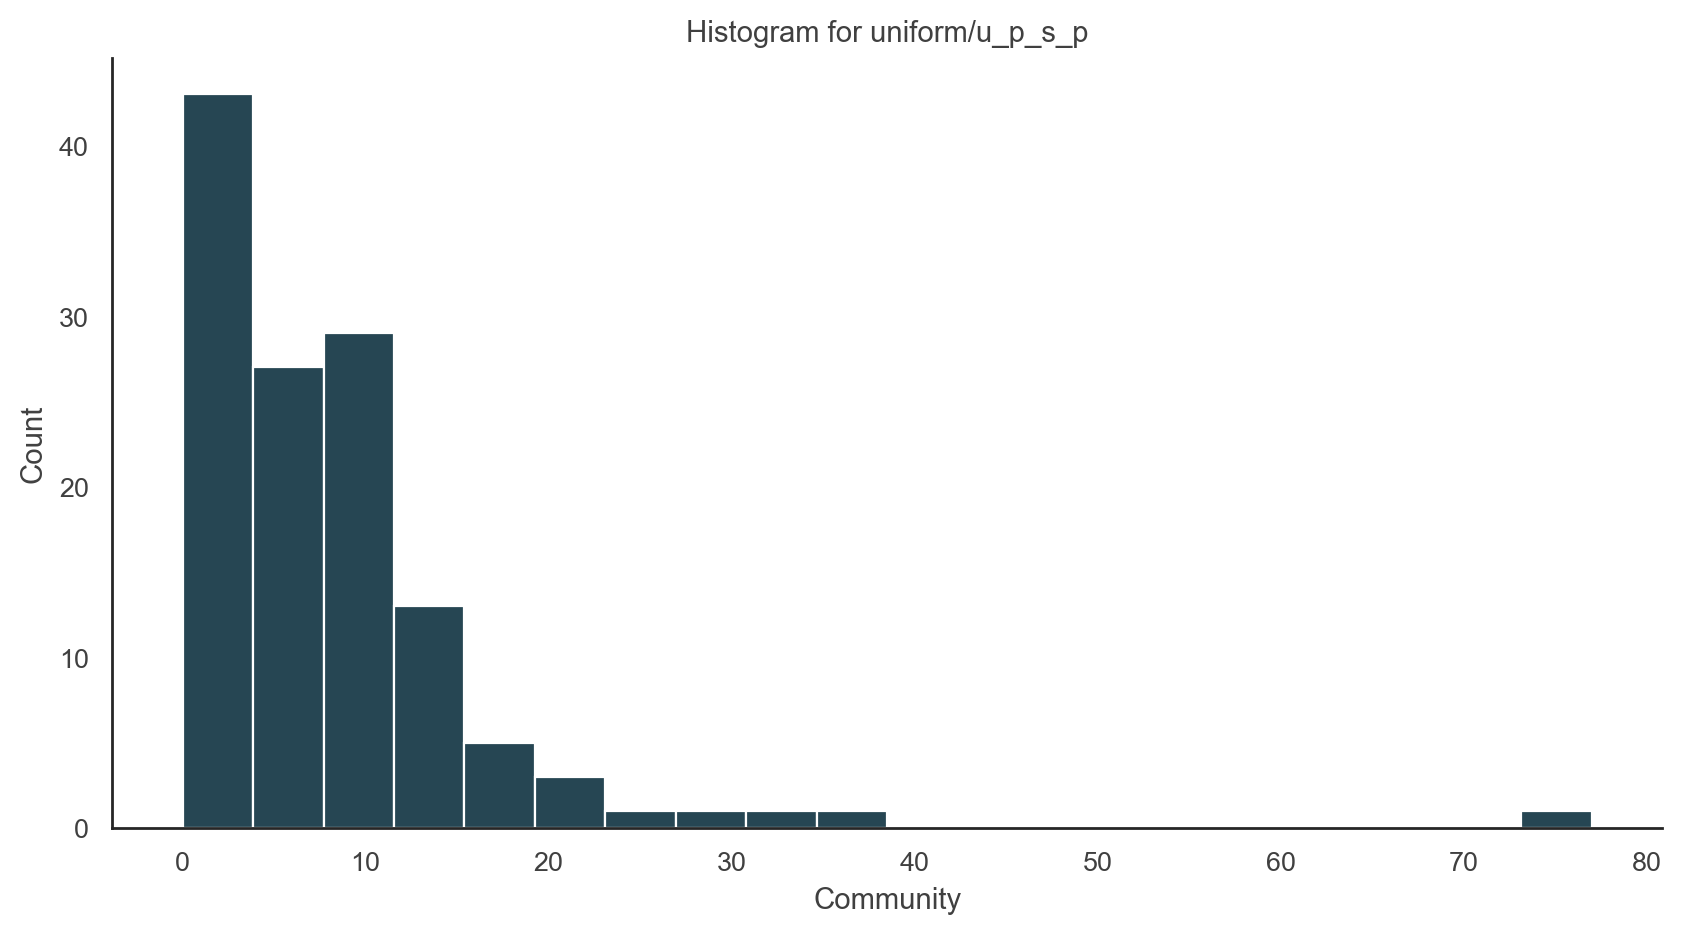

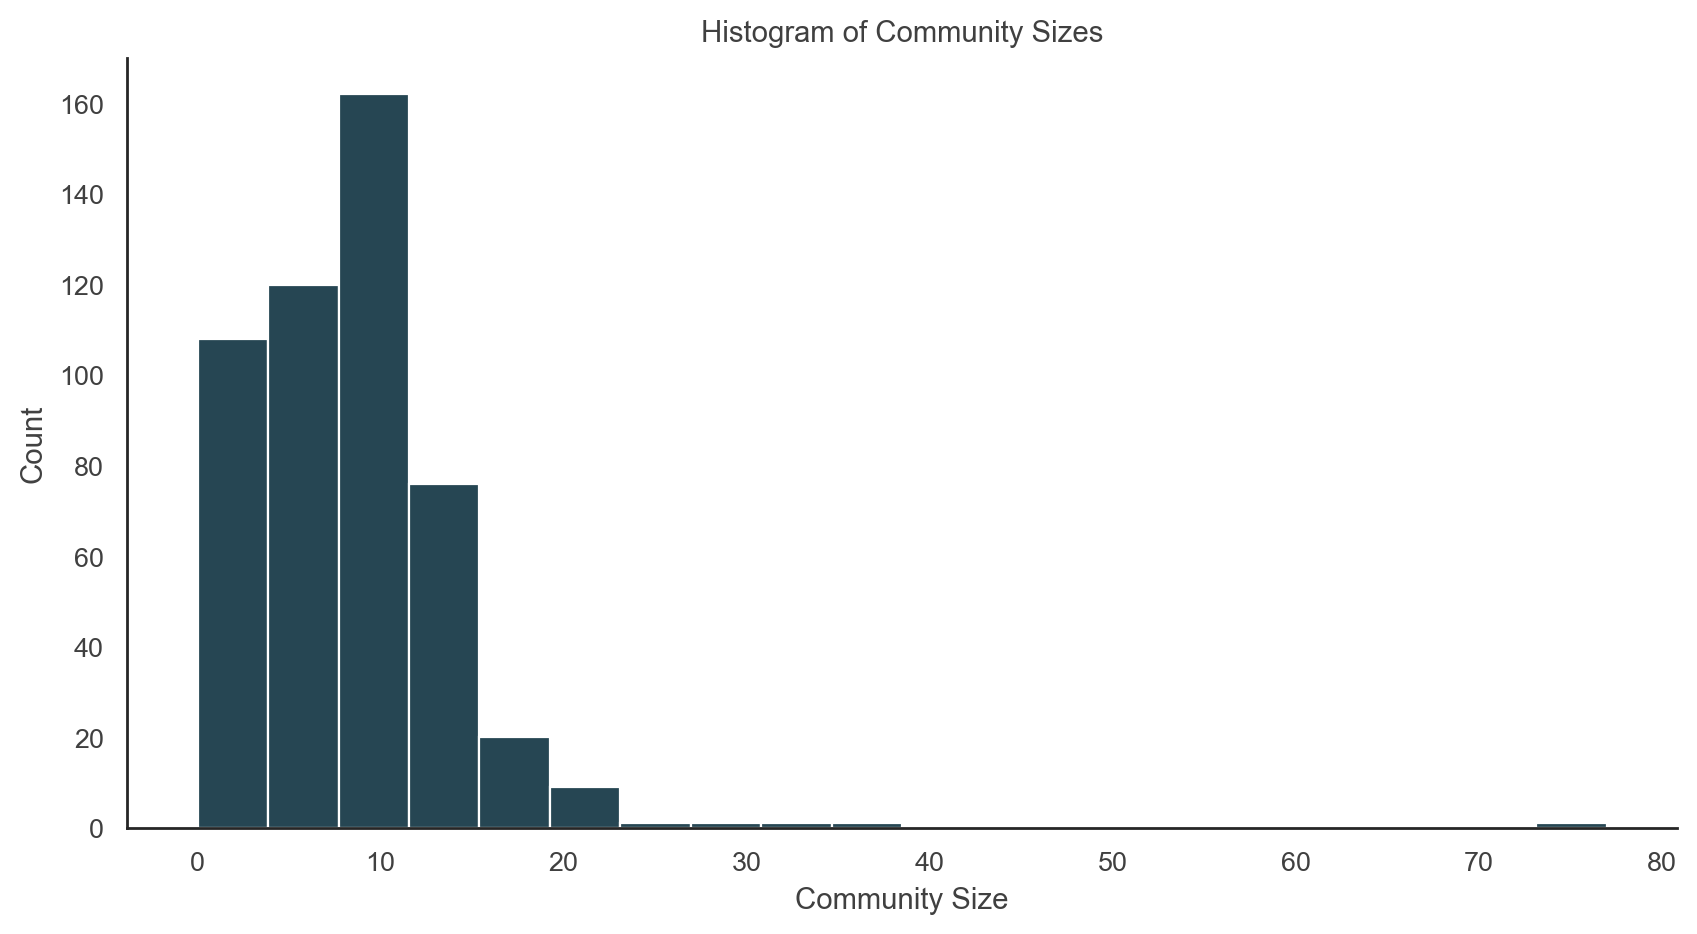

In [239]:
import matplotlib.pyplot as plt

# For each row in the dataframe
for index, row in df.iterrows():
    plt.figure(figsize=(10, 5))
    plt.hist(row, bins=20)
    plt.xlabel('Community')
    plt.ylabel('Count')
    plt.title(f'Histogram for {index}')
    plt.show()

# Flatten the DataFrame into a single series
sizes = df.values.flatten()

# Plot a histogram of the community sizes
plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=20)
plt.xlabel('Community Size')
plt.ylabel('Count')
plt.title('Histogram of Community Sizes')
plt.show()

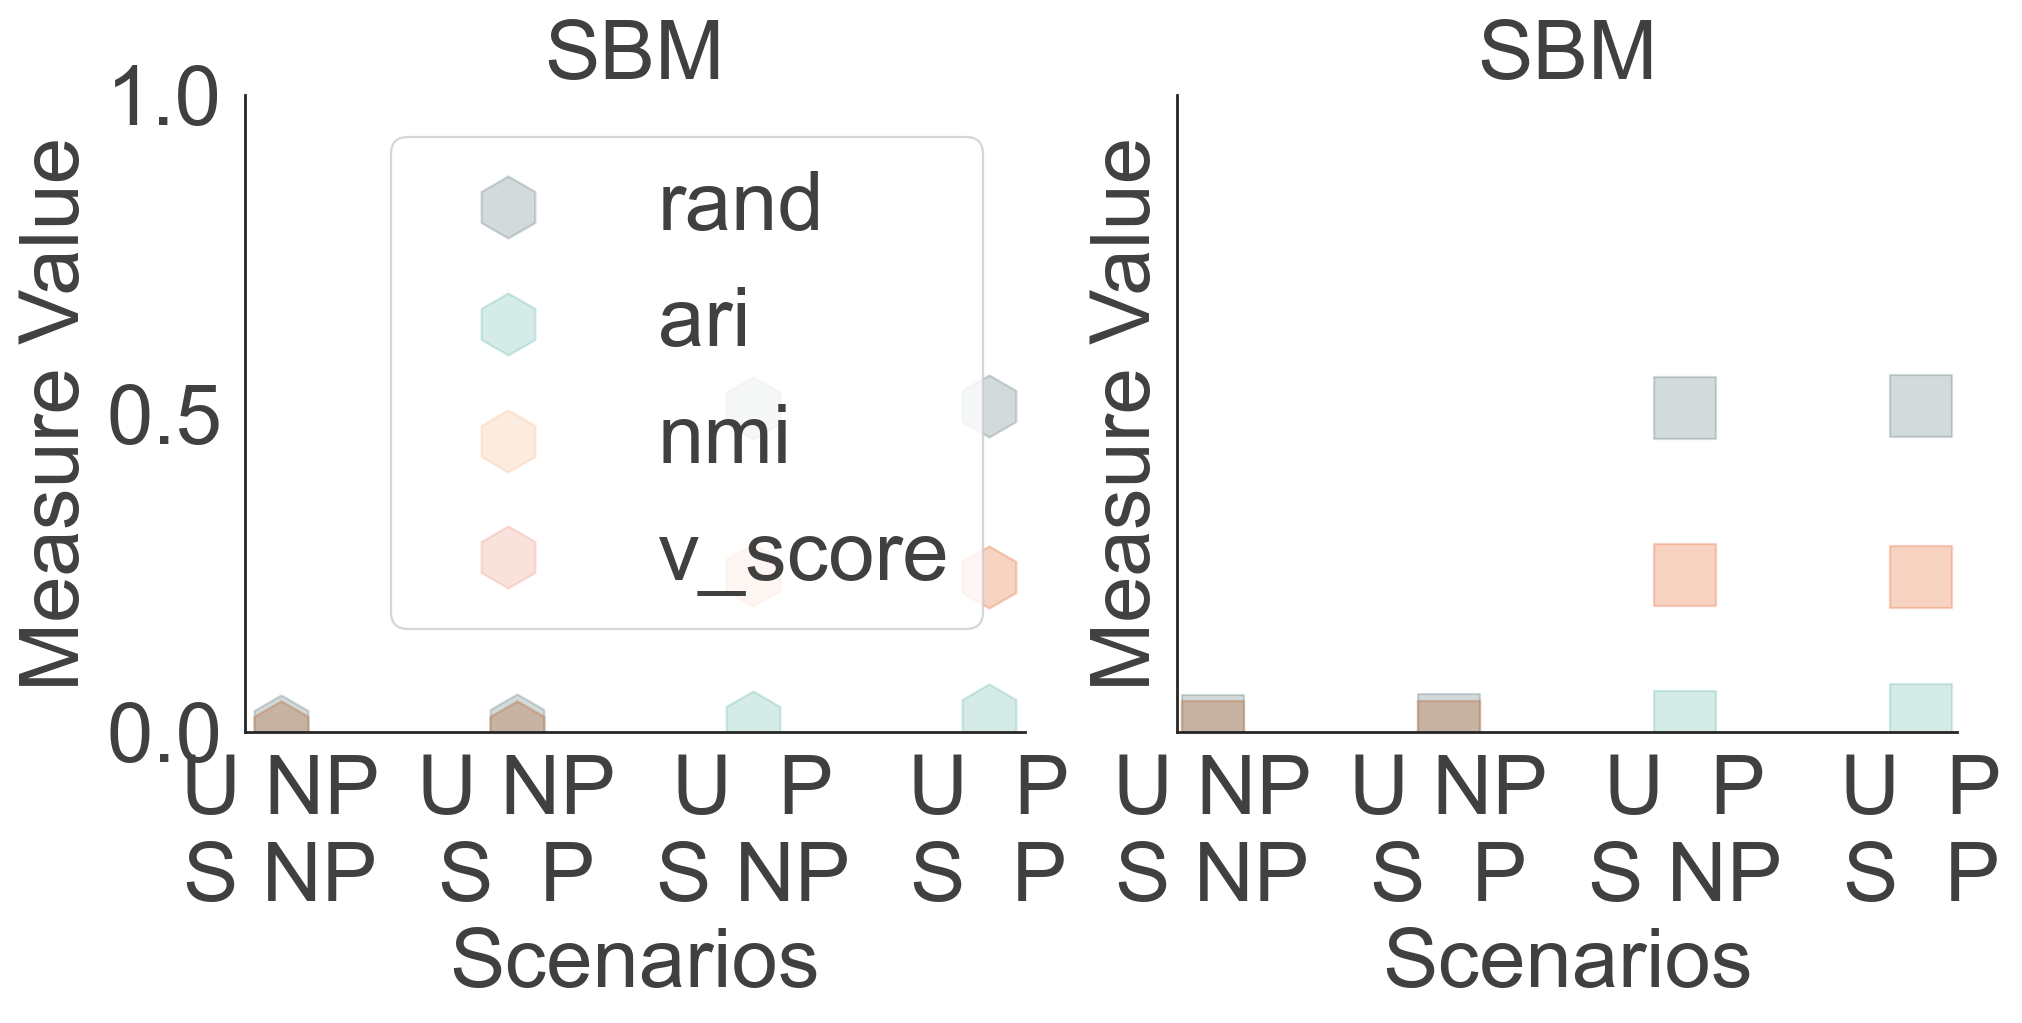

In [240]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize = (10,5), dpi =200, constrained_layout=True, sharey=True)

i = 0
for df, ax in zip(dfs, axs.ravel()):
    
    if i == 0:
        # For each column in the dataframe
        for column in df.columns:
            #plt.plot(df.index, df[column], label=column)
            ax.scatter(df.index, df[column], label=column, s = 500, marker = 'h', alpha = 0.2)
        ax.legend(fontsize = text_size)
        
    else:
        # For each column in the dataframe
        for column in df.columns:
            #plt.plot(df.index, df[column], label=column)
            ax.scatter(df.index, df[column], label= column,s = 500, marker = 's', alpha = 0.2)
    i += 1


    ax.set_ylim(0,1)
    ax.set_xlabel('Scenarios', fontsize =text_size)
    ax.set_ylabel('Measure Value', fontsize =text_size)
    ax.set_title(f'SBM', fontsize =text_size)
    ax.tick_params(axis='both', labelsize=text_size)

    
    
plt.show()

### SBM - not deg. corr.

In [241]:
mats, labels = load_data('./data/meneame/synth/uniform/')

dfs = []

for w in ['weighted', 'unweighted']:
    df = pd.DataFrame(columns = ['rand', 'ari', 'nmi', 'v_score'], index = titles)
    for i in range(len(mats)):
        label = labels[i]
        scenario = uniform_scenarios[i]
        title = titles[i]
        mat = mats[i]
        graph_build = SignedNetwork()
        g = graph_build.graph_construction(repre=mat, repre_type='adj', is_directed=check_if_directed(mat))
        folder = get_folder('meneame',synth = True,scenario= scenario,method='sbm',weighted=True,year=0)
        with open(f'{folder}sbm_not_deg_corr.pkl', 'rb') as f:
            sbm = pickle.load(f)
            print(sbm)
        g.vp['membership'] = g.new_vertex_property(value_type="double", vals=sbm)
        g.vp['labels'] = g.new_vertex_property(value_type="double", vals=label)

        df['rand'][title] = rand_score(list(g.vp['labels']), list(g.vp['membership']))
        df['ari'][title] = adjusted_rand_score(list(g.vp['labels']), list(g.vp['membership']))
        df['nmi'][title] = normalized_mutual_info_score(list(g.vp['labels']), list(g.vp['membership']))
        df['v_score'][title] = v_measure_score(list(g.vp['labels']), list(g.vp['membership']))
    dfs.append(df)

print(dfs)



# Initialize an empty dictionary to store the counts
counts_dict = {}

for scenario in uniform_scenarios:
    folder = get_folder('meneame',synth = True,scenario= scenario,method='sbm',weighted=True,year=0)
    with open(f'{folder}sbm_not_deg_corr.pkl', 'rb') as f:
        sbm = pickle.load(f)
    labels, counts = np.unique(sbm, return_counts=True)

    # Create a dictionary for the current combination of gamma and lambd
    current_counts = dict(zip(labels, counts))

    # Add the current counts to the overall counts dictionary
    counts_dict[scenario] = current_counts

# Convert the counts dictionary to a DataFrame
df = pd.DataFrame(counts_dict).T

# Set the column names
df.columns = [f'comm. {label}' for label in df.columns]



# Replace NaN values with zeros
df = df.fillna(0)

df = df.astype(int)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 15, 31, 32, 20, 33, 34, 35, 11, 31, 19, 33, 12, 20, 36, 37, 34, 38, 25, 0, 39, 40, 41, 42, 43, 21, 3, 20, 36, 44, 45, 46, 47, 46, 38, 18, 44, 48, 39, 48, 32, 49, 50, 51, 52, 53, 54, 24, 48, 55, 10, 55, 56, 57, 58, 28, 25, 8, 58, 17, 7, 23, 33, 52, 59, 60, 61, 54, 62, 41, 18, 10, 63, 64, 65, 8, 66, 22, 54, 43, 67, 20, 46, 65, 68, 11, 0, 56, 49, 10, 69, 5, 21, 16, 62, 28, 20, 18, 70, 71, 44, 37, 27, 21, 3, 72, 4, 12, 41, 73, 71, 6, 28, 14, 74, 75, 76, 2, 74, 72, 77, 43, 10, 17, 78, 79, 19, 30, 6, 60, 61, 10, 78, 63, 26, 3, 60, 5, 31, 24, 80, 81, 58, 82, 9, 41, 47, 35, 62, 83, 36, 50, 21, 54, 56, 26, 84, 16, 74, 85, 86, 46, 2, 72, 2, 70, 84, 61, 87, 27, 86, 45, 75, 37, 87, 45, 20, 70, 35, 58, 64, 79, 45, 39, 11, 88, 8, 58, 89, 36, 27, 90, 71, 87, 15, 10, 12, 24, 50, 76, 21, 69, 31, 79, 36, 91, 10, 0, 9, 73, 80, 79, 52, 44, 68, 3, 22, 25, 66, 63, 37, 65, 57, 92, 65, 38, 57

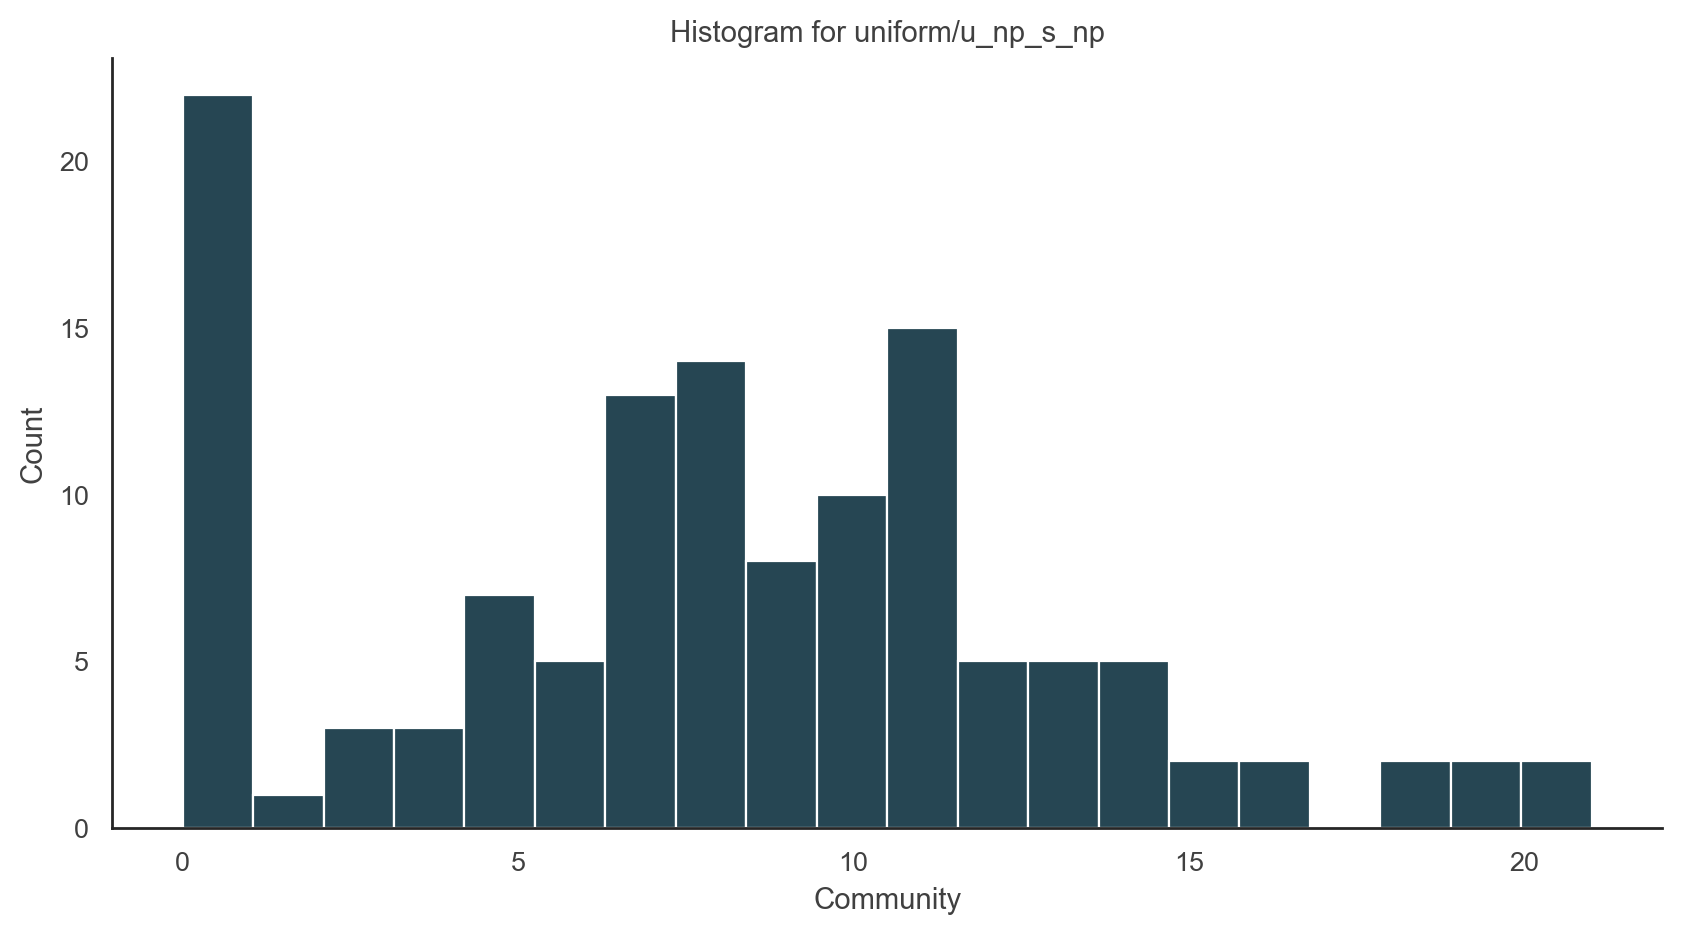

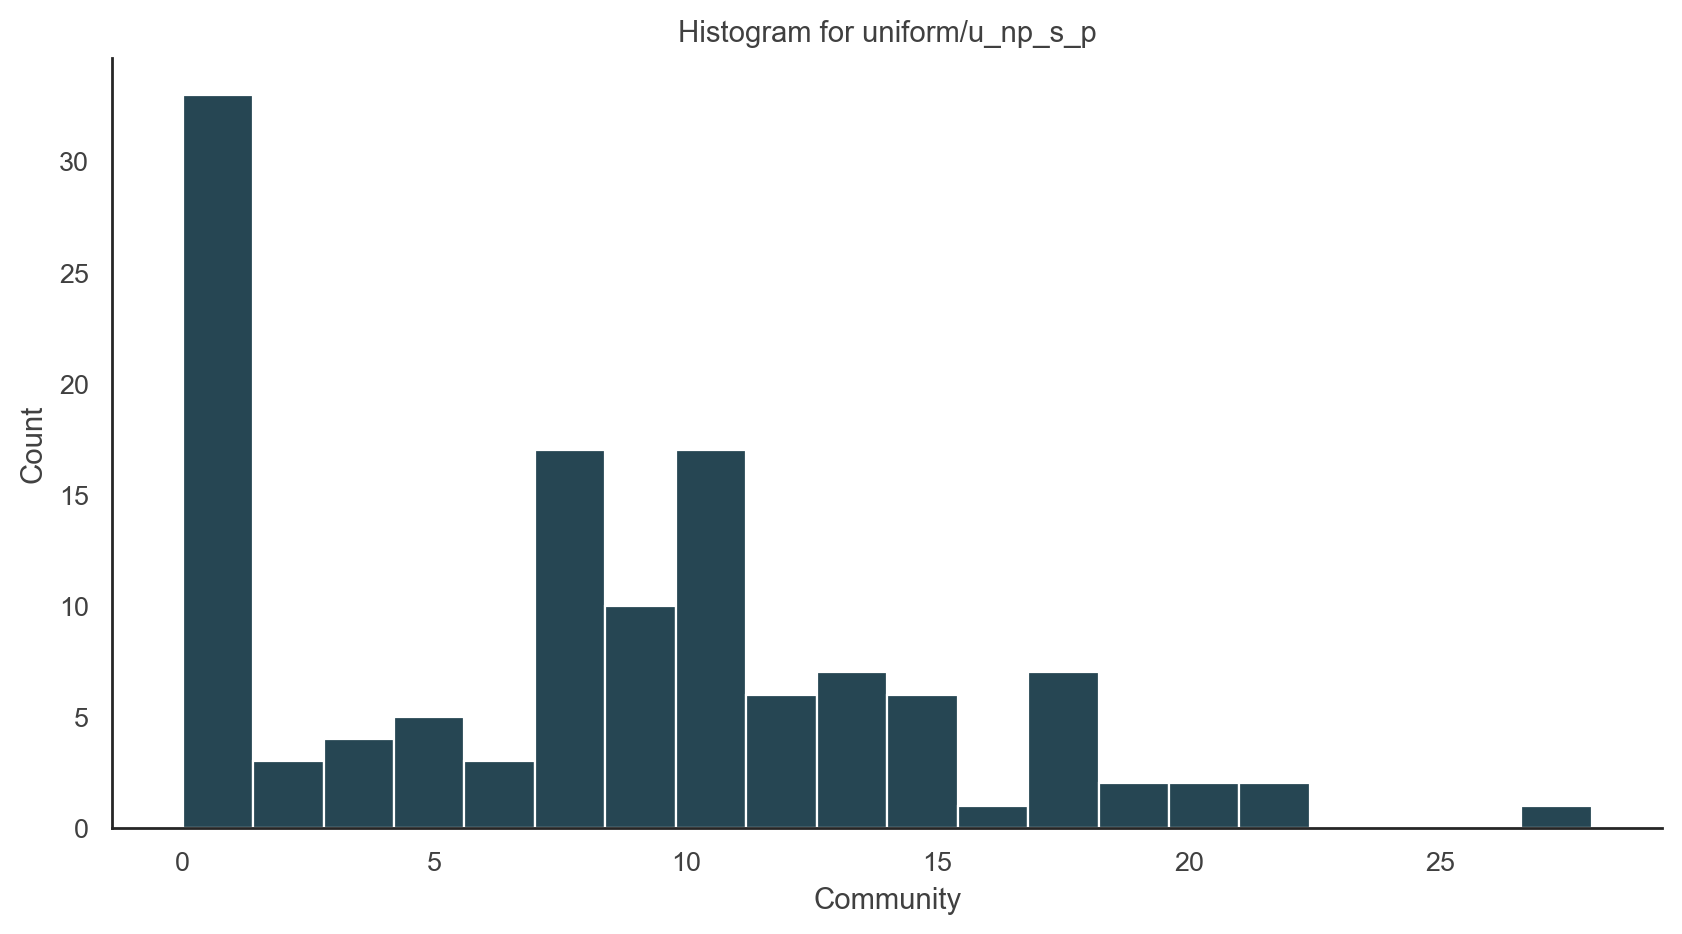

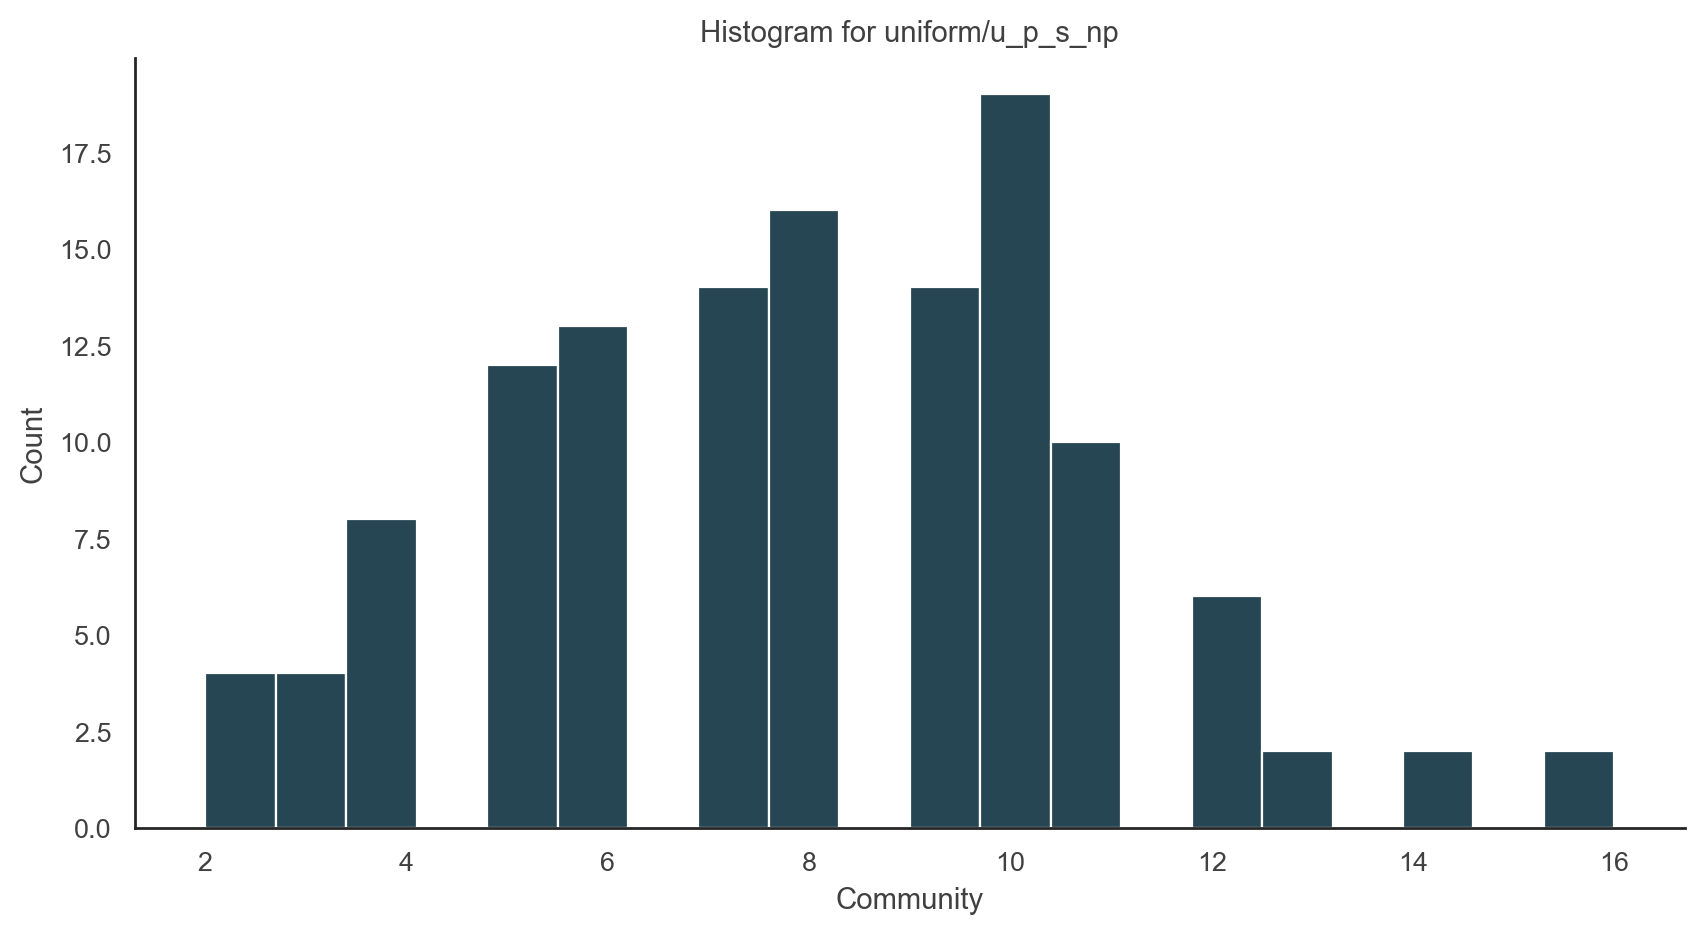

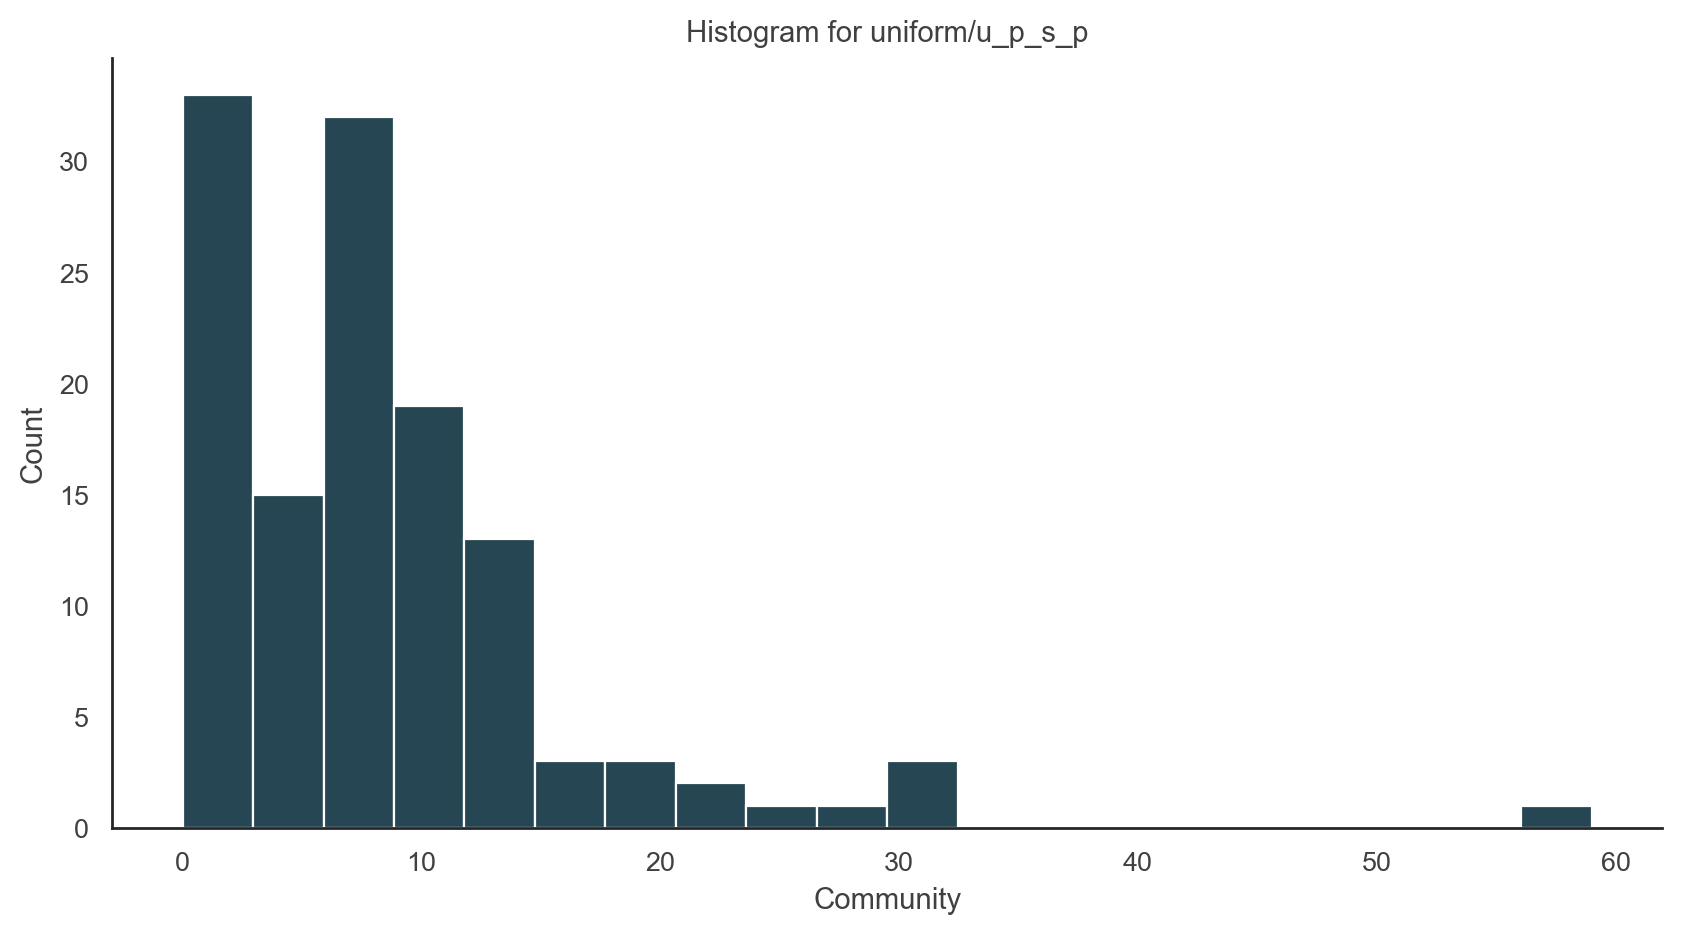

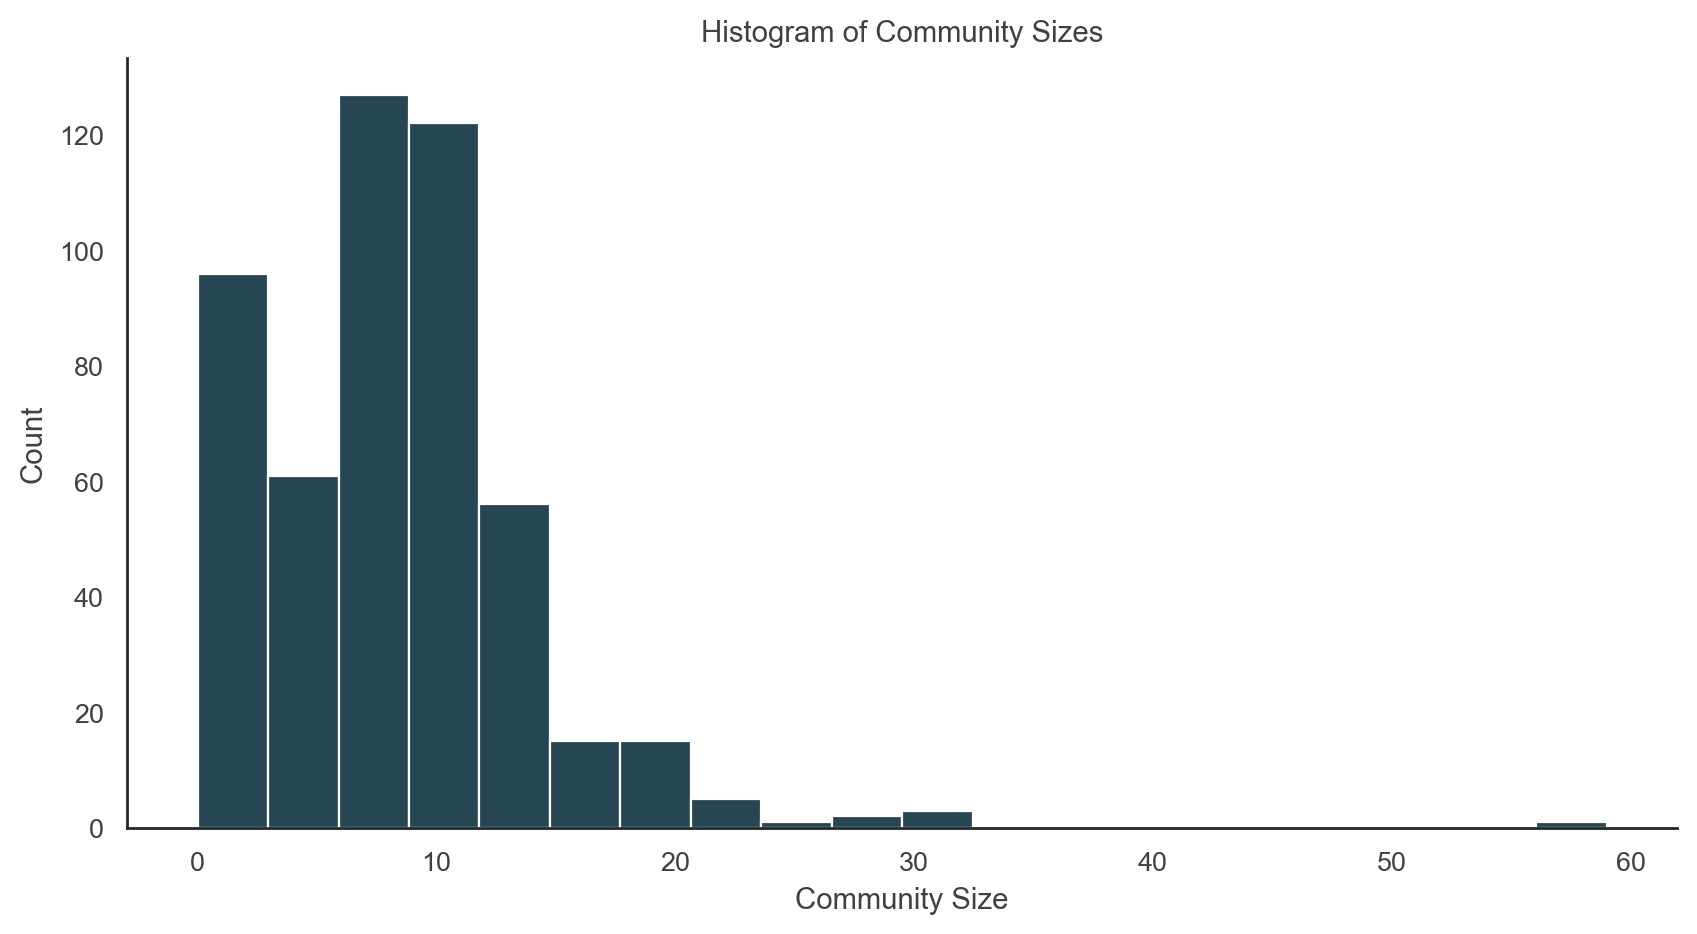

In [242]:
# For each row in the dataframe
for index, row in df.iterrows():
    plt.figure(figsize=(10, 5))
    plt.hist(row, bins=20)
    plt.xlabel('Community')
    plt.ylabel('Count')
    plt.title(f'Histogram for {index}')
    plt.show()

# Flatten the DataFrame into a single series
sizes = df.values.flatten()

# Plot a histogram of the community sizes
plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=20)
plt.xlabel('Community Size')
plt.ylabel('Count')
plt.title('Histogram of Community Sizes')
plt.show()

### Degree corrected

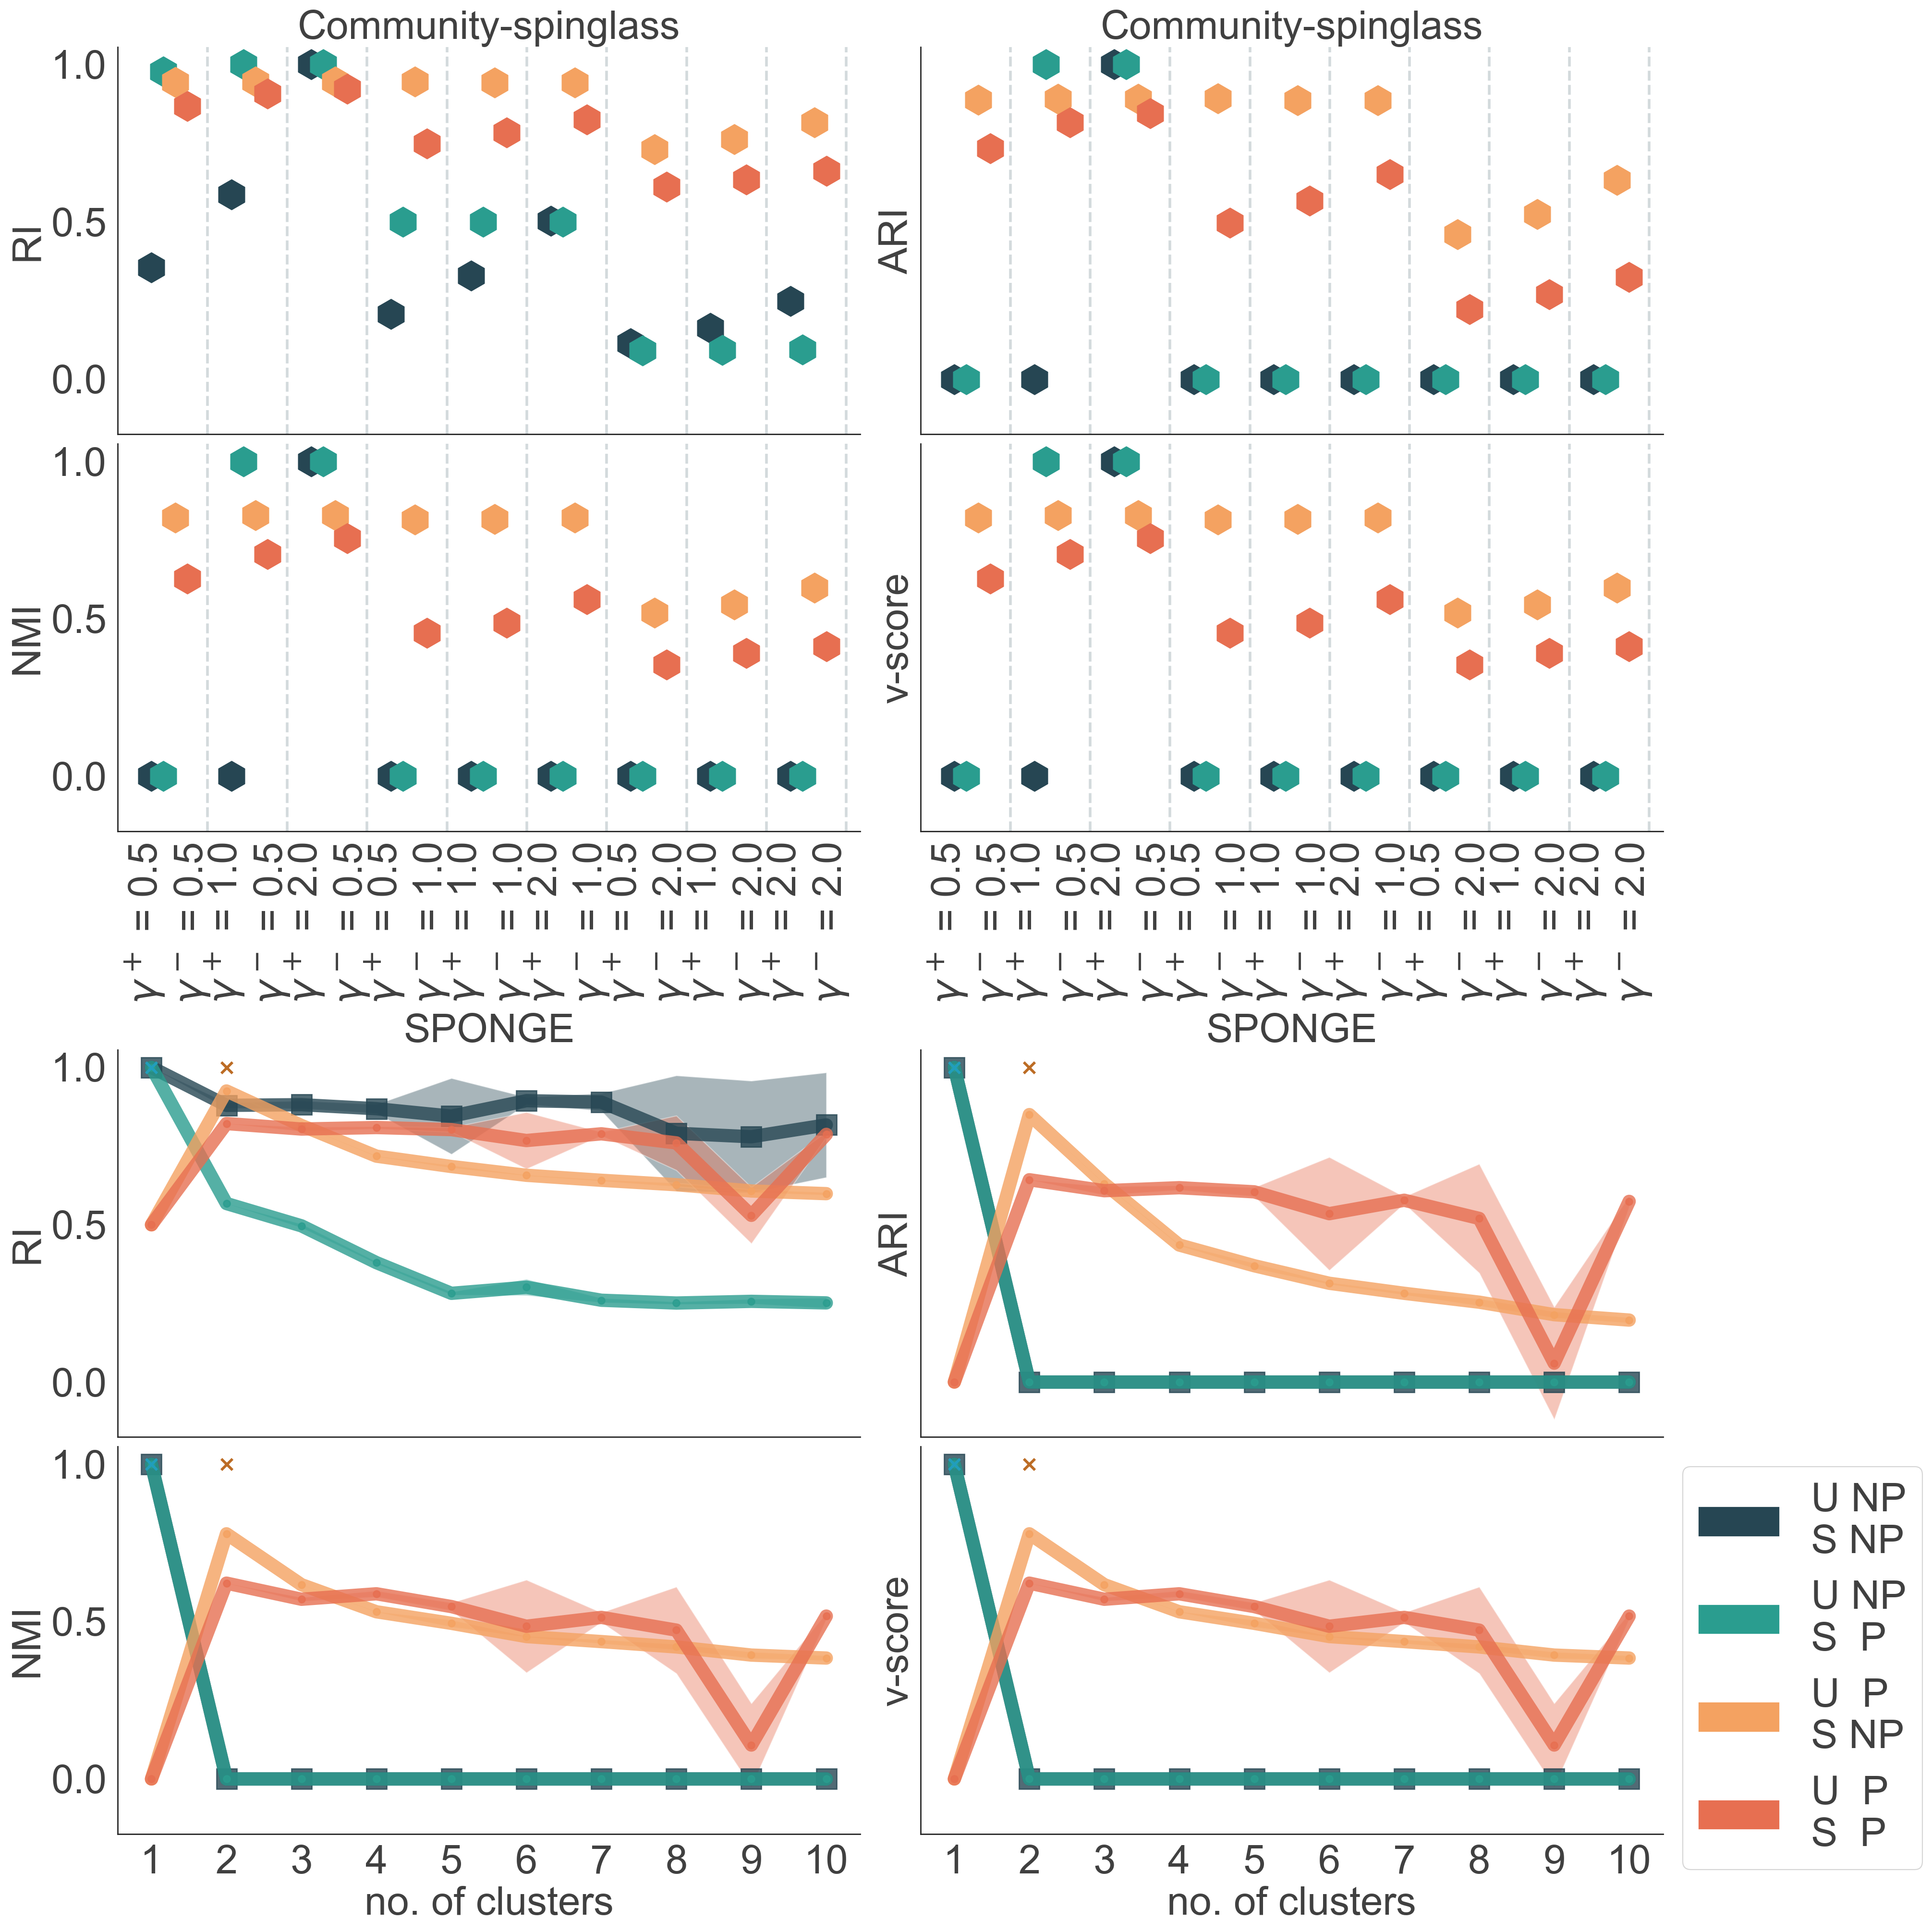

In [243]:
gammas = [0.5, 1, 2]
lambdas = [0.5, 1, 2]

mats, labels = load_data('./data/meneame/synth/deg_corr/')
fig, axs = plt.subplots(4, 2, figsize = (20,20),dpi =200, sharey=True, constrained_layout=True)


j = 0
for m, ax in zip(measures+measures, axs.ravel()):
    if j < 4:
        dfs = rand_score_df(method='spinglass',dataset='meneame',mats= mats, labels=labels, scenarios=deg_corr_scenarios,synth=True, metrics=m)
        
        if j == 0 or j == 1:  
            ax.set_title(f'Community-spinglass', size = text_size)
            plot_spinglass_synth(ax, dfs[::2], lambdas, gammas, titles, text_size, xticks = False)
        else:
            plot_spinglass_synth(ax, dfs[::2], lambdas, gammas, titles, text_size, xticks = True)
        ax.set_ylabel((measures_labels+measures_labels)[j], size =text_size)
        j+=1
    else:
        df, df_std = rand_score_df(method='sponge',dataset='meneame',mats= mats, scenarios=deg_corr_scenarios,labels=labels,synth=True, metrics=m)
        if j == 4 or j == 5:
            ax.set_title(f'SPONGE', size = text_size)
            plot_sponge_synth(ax, df, df_std, text_size, titles, xticks=False)
        else:
            plot_sponge_synth(ax, df, df_std, text_size, titles, xticks=True)
        ax.set_ylabel((measures_labels+measures_labels)[j], fontsize =text_size)
        j+=1


save_plot(path = './plots/deg_corr/', filename = 'metrics_comparison.pdf')
plt.show()

In [244]:
from src.signet import *

mats, labels = load_data('./data/meneame/synth/deg_corr/')

dfs = []

for w in ['weighted', 'unweighted']:
    df = pd.DataFrame(columns = ['rand', 'ari', 'nmi', 'v_score'], index = titles)
    for i in range(len(mats)):
        label = labels[i]
        scenario = deg_corr_scenarios[i]
        title = titles[i]
        mat = mats[i]
        graph_build = SignedNetwork()
        g = graph_build.graph_construction(repre=mat, repre_type='adj', is_directed=check_if_directed(mat))
        folder = get_folder('meneame',synth = True,scenario= scenario,method='sbm',weighted=True,year=0)
        with open(f'{folder}sbm_deg_corr.pkl', 'rb') as f:
            sbm = pickle.load(f)
            print(sbm)
        g.vp['membership'] = g.new_vertex_property(value_type="double", vals=sbm)
        g.vp['labels'] = g.new_vertex_property(value_type="double", vals=label)

        df['rand'][title] = rand_score(list(g.vp['labels']), list(g.vp['membership']))
        df['ari'][title] = adjusted_rand_score(list(g.vp['labels']), list(g.vp['membership']))
        df['nmi'][title] = normalized_mutual_info_score(list(g.vp['labels']), list(g.vp['membership']))
        df['v_score'][title] = v_measure_score(list(g.vp['labels']), list(g.vp['membership']))
    dfs.append(df)

print(dfs)

import pandas as pd

# Initialize an empty dictionary to store the counts
counts_dict = {}

for scenario in deg_corr_scenarios:
    folder = get_folder('meneame',synth = True,scenario= scenario,method='sbm',weighted=True,year=0)
    with open(f'{folder}sbm_deg_corr.pkl', 'rb') as f:
        sbm = pickle.load(f)
    labels, counts = np.unique(sbm, return_counts=True)

    # Create a dictionary for the current combination of gamma and lambd
    current_counts = dict(zip(labels, counts))

    # Add the current counts to the overall counts dictionary
    counts_dict[scenario] = current_counts

# Convert the counts dictionary to a DataFrame
df = pd.DataFrame(counts_dict).T

# Set the column names
df.columns = [f'comm. {label}' for label in df.columns]



# Replace NaN values with zeros
df = df.fillna(0)

df = df.astype(int)

[0, 1, 0, 2, 3, 4, 5, 6, 6, 7, 8, 5, 7, 4, 1, 9, 10, 11, 12, 13, 6, 14, 13, 15, 0, 10, 13, 7, 7, 16, 4, 17, 7, 14, 4, 18, 13, 19, 13, 17, 20, 14, 7, 11, 7, 18, 21, 15, 20, 19, 2, 7, 22, 2, 20, 20, 7, 13, 23, 24, 4, 25, 0, 4, 7, 25, 20, 20, 17, 0, 11, 19, 2, 7, 26, 14, 19, 10, 7, 0, 7, 20, 15, 27, 5, 10, 17, 2, 13, 28, 17, 4, 20, 13, 29, 7, 11, 19, 6, 0, 7, 22, 7, 3, 10, 13, 5, 1, 2, 2, 1, 1, 7, 4, 14, 27, 19, 4, 0, 13, 15, 4, 10, 14, 7, 0, 7, 20, 0, 20, 6, 2, 17, 4, 10, 13, 6, 13, 20, 20, 13, 15, 14, 15, 3, 20, 6, 26, 27, 23, 2, 7, 2, 2, 13, 14, 11, 9, 2, 12, 7, 7, 0, 19, 29, 4, 5, 11, 27, 25, 29, 0, 14, 26, 5, 28, 2, 0, 7, 21, 30, 15, 2, 24, 27, 12, 5, 1, 7, 26, 6, 17, 2, 7, 11, 14, 29, 7, 4, 7, 4, 11, 19, 11, 7, 29, 31, 13, 25, 0, 2, 7, 23, 2, 18, 29, 2, 2, 2, 7, 21, 16, 5, 14, 29, 1, 10, 7, 23, 30, 20, 7, 24, 5, 0, 20, 4, 14, 15, 2, 15, 20, 23, 28, 11, 27, 16, 11, 28, 17, 7, 16, 28, 13, 6, 11, 7, 19, 32, 7, 20, 2, 15, 7, 27, 20, 12, 13, 33, 13, 0, 5, 2, 29, 7, 13, 14, 4, 28, 6, 7, 1

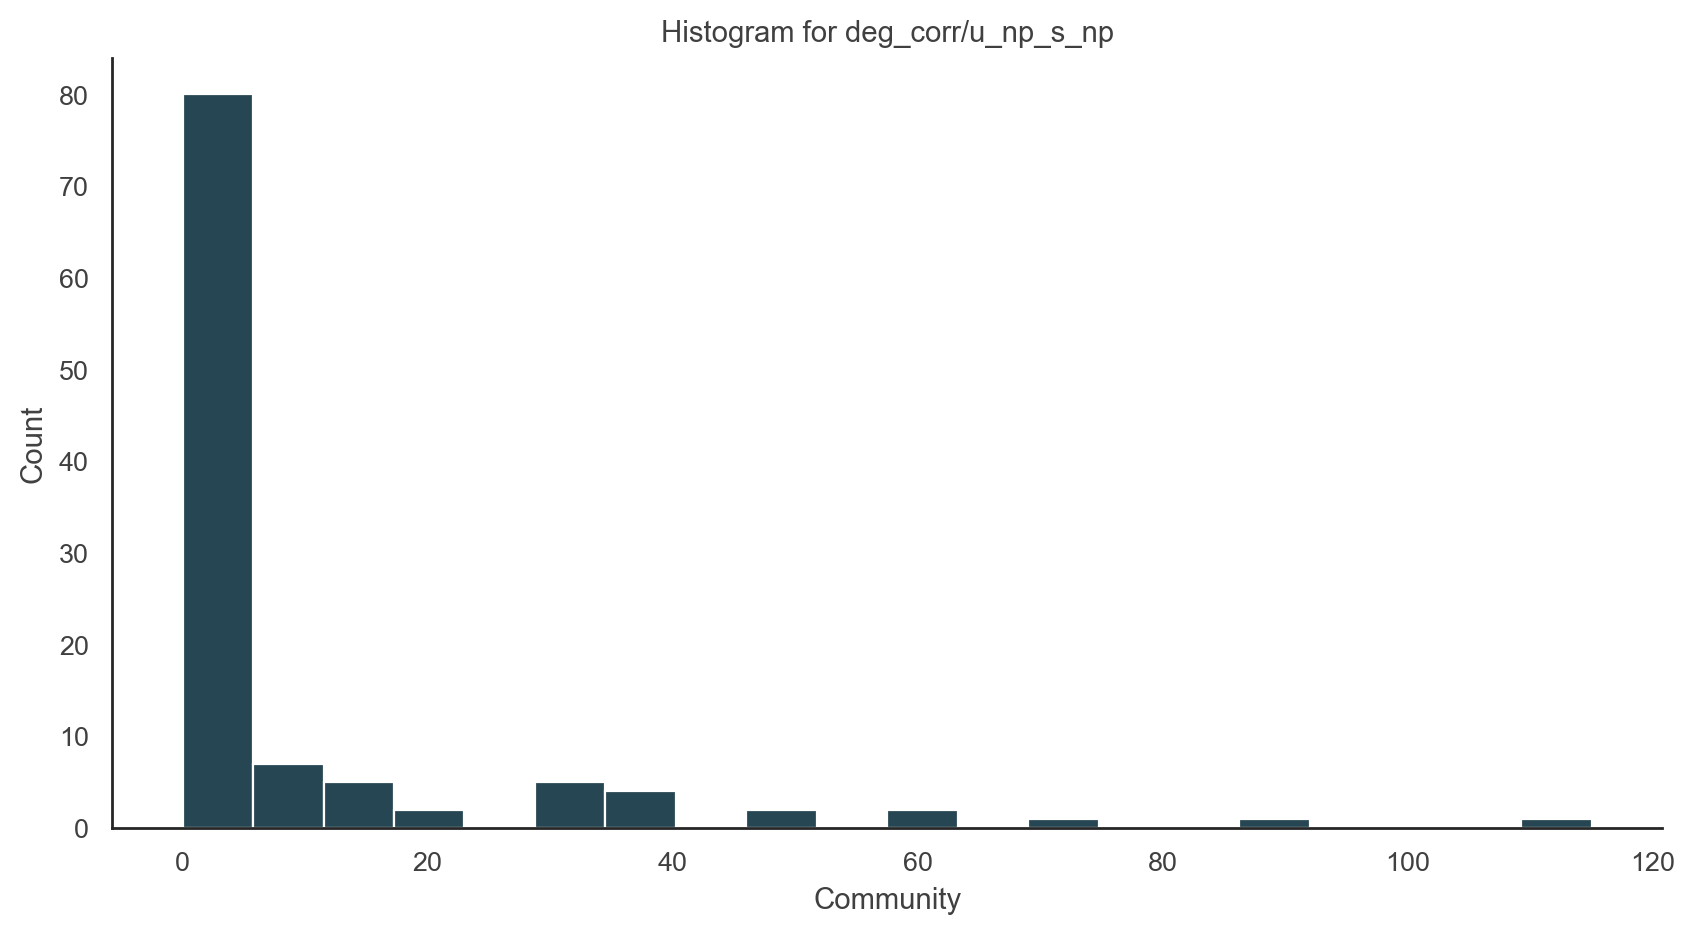

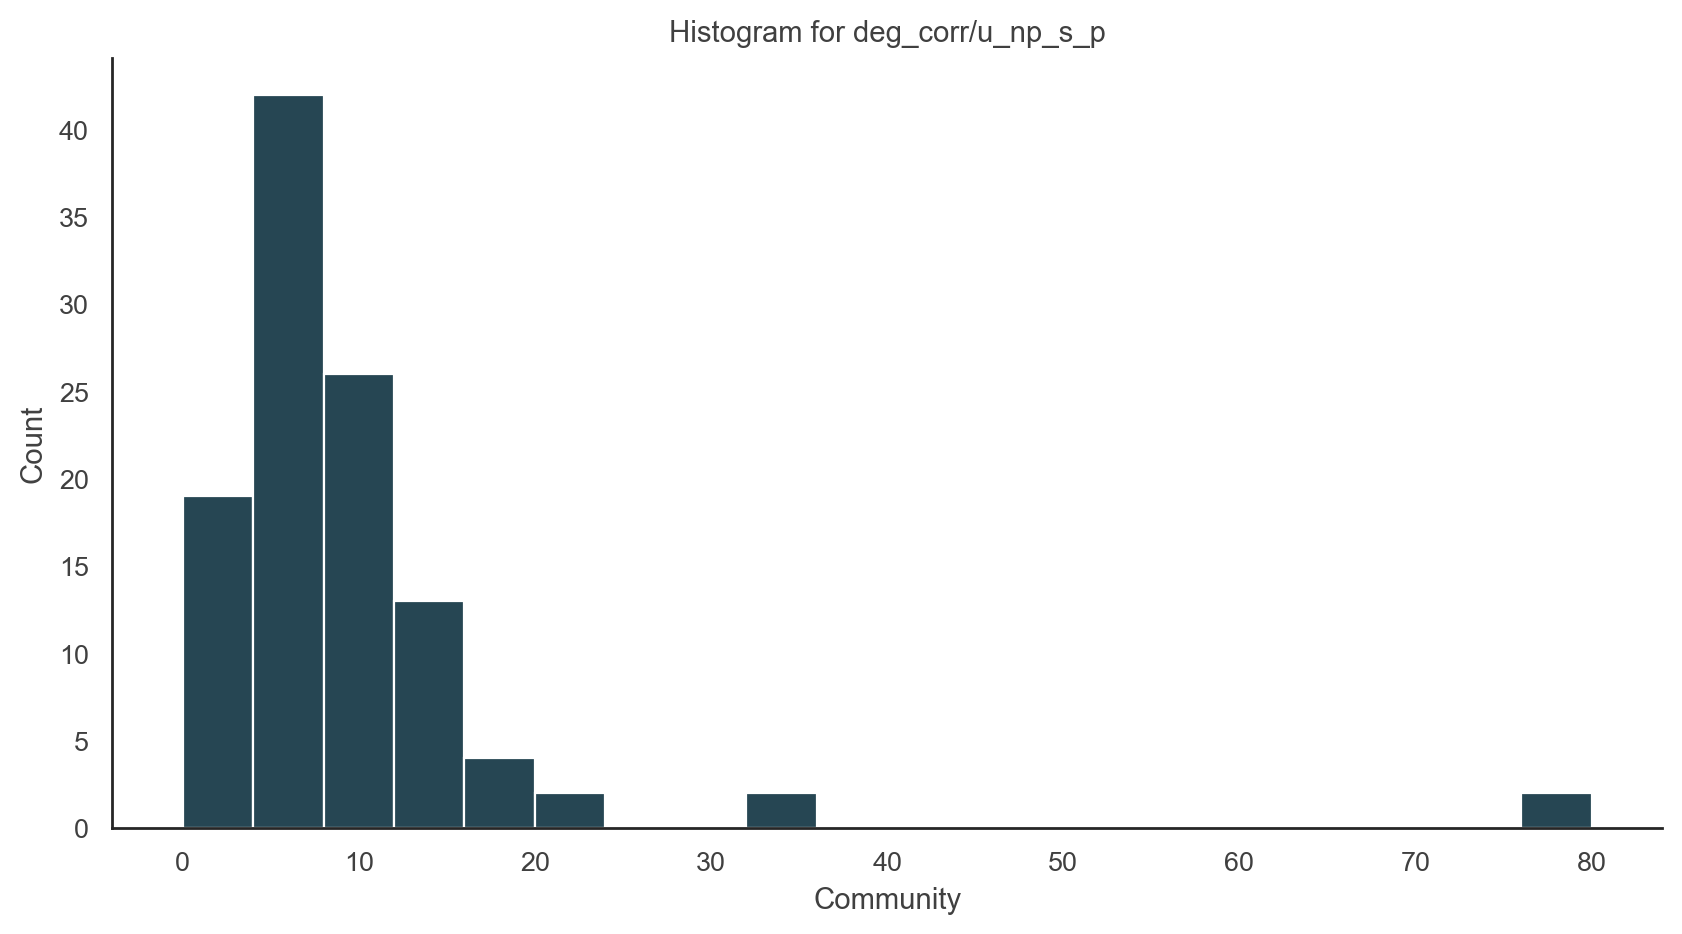

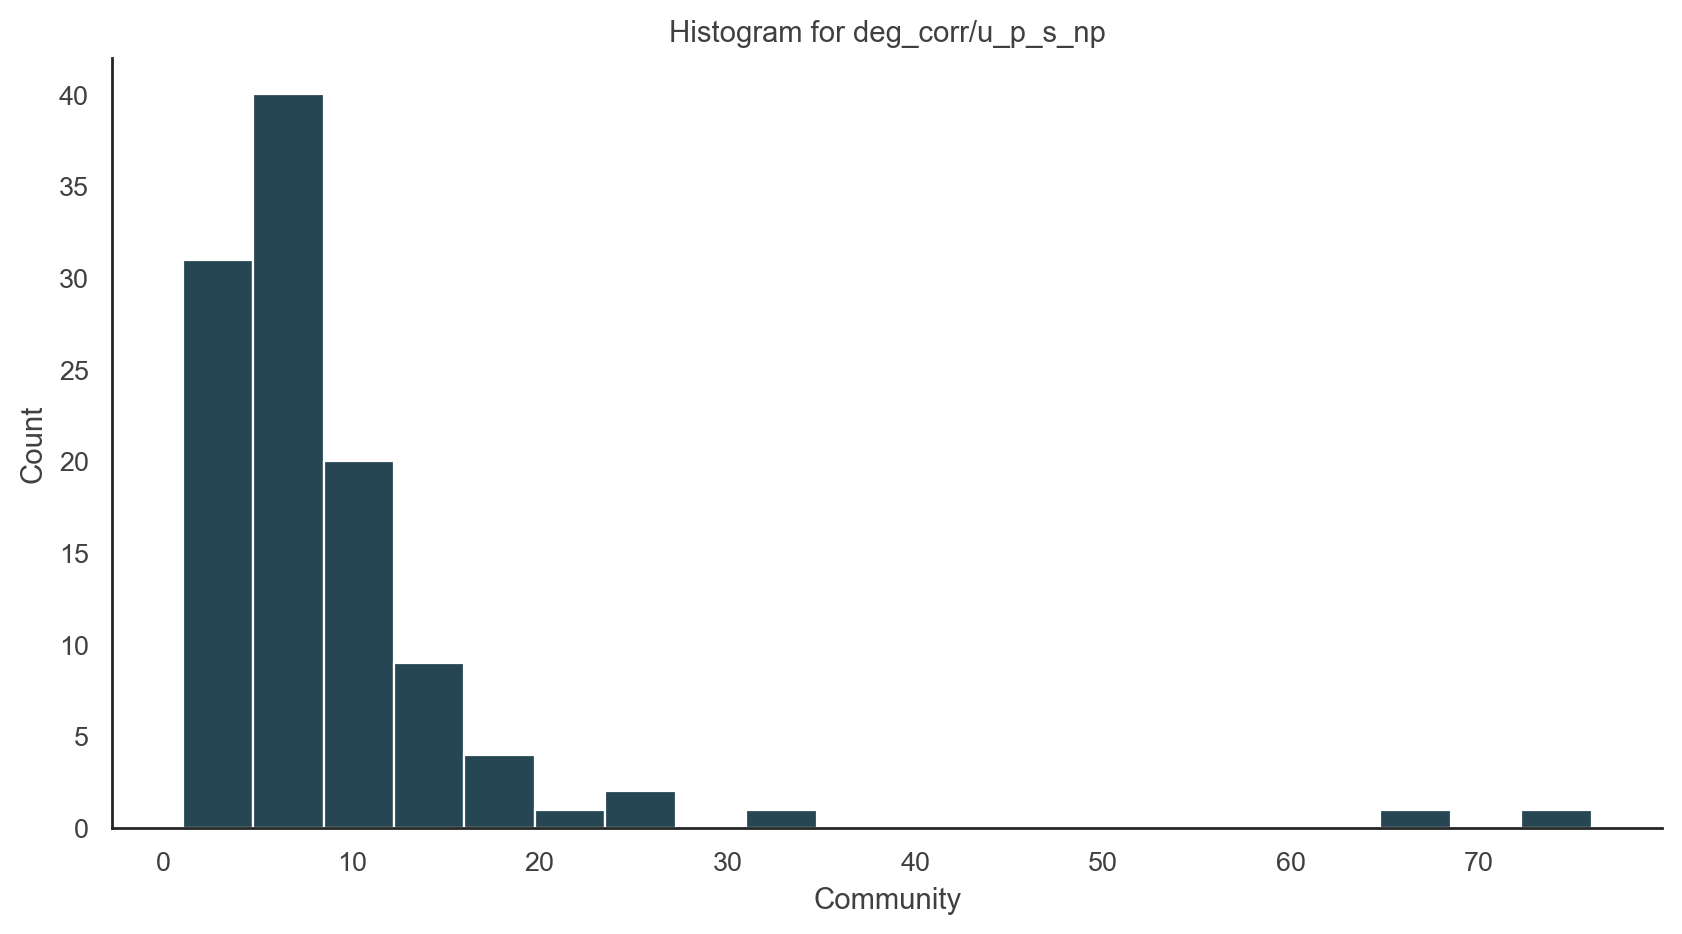

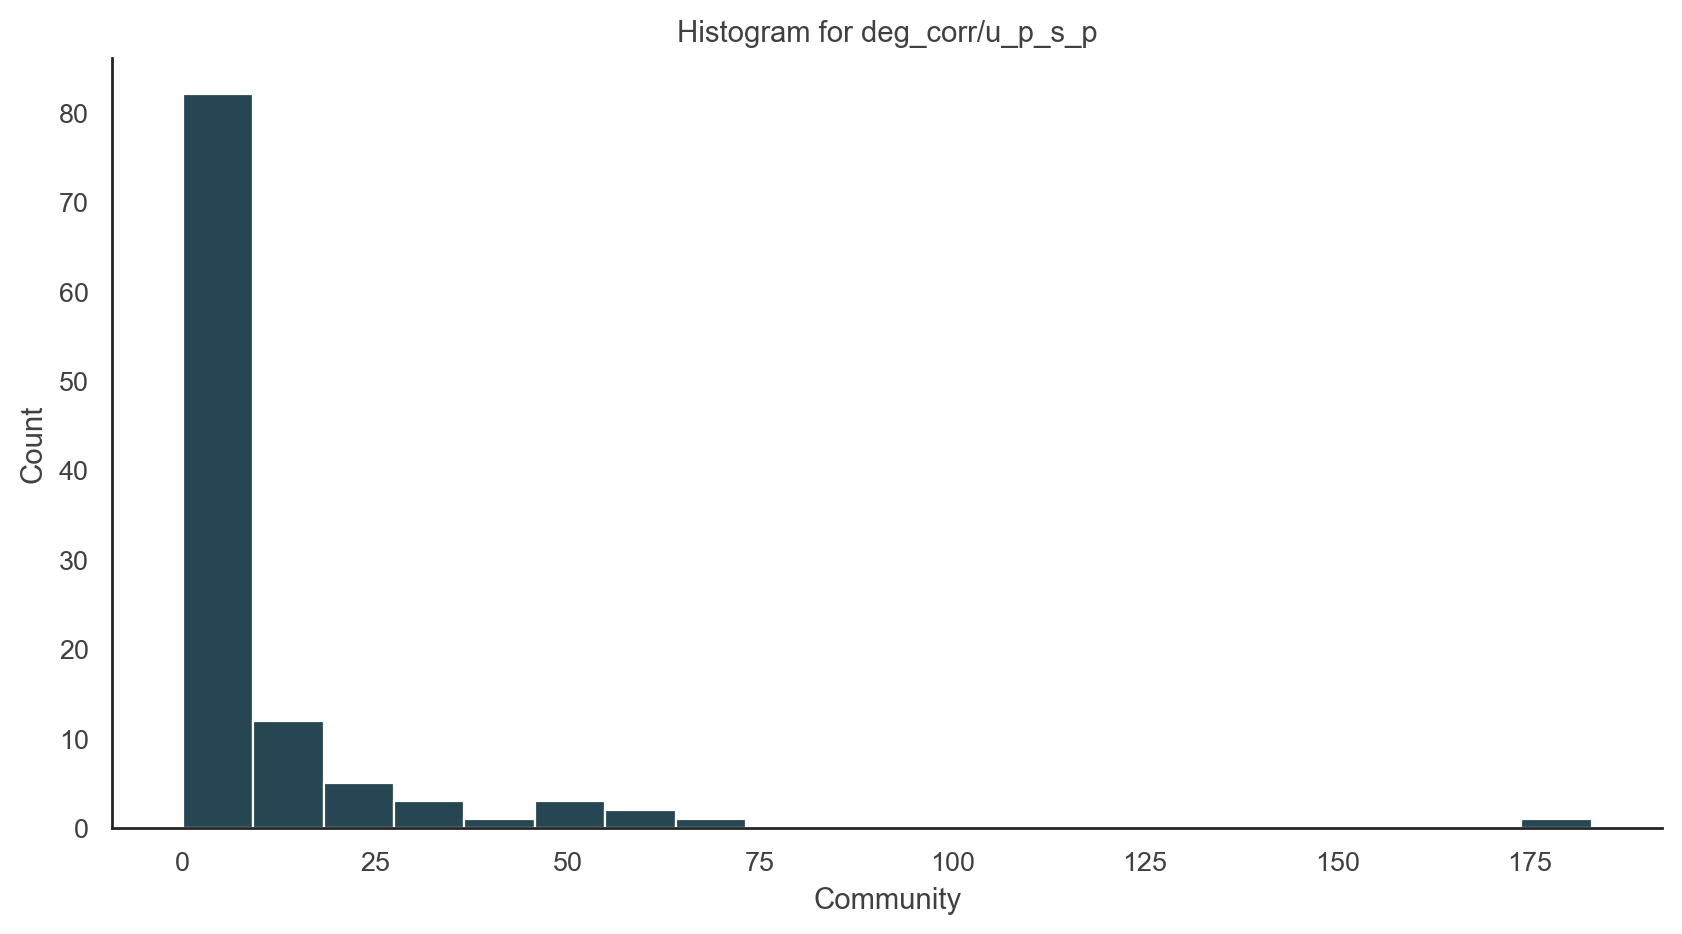

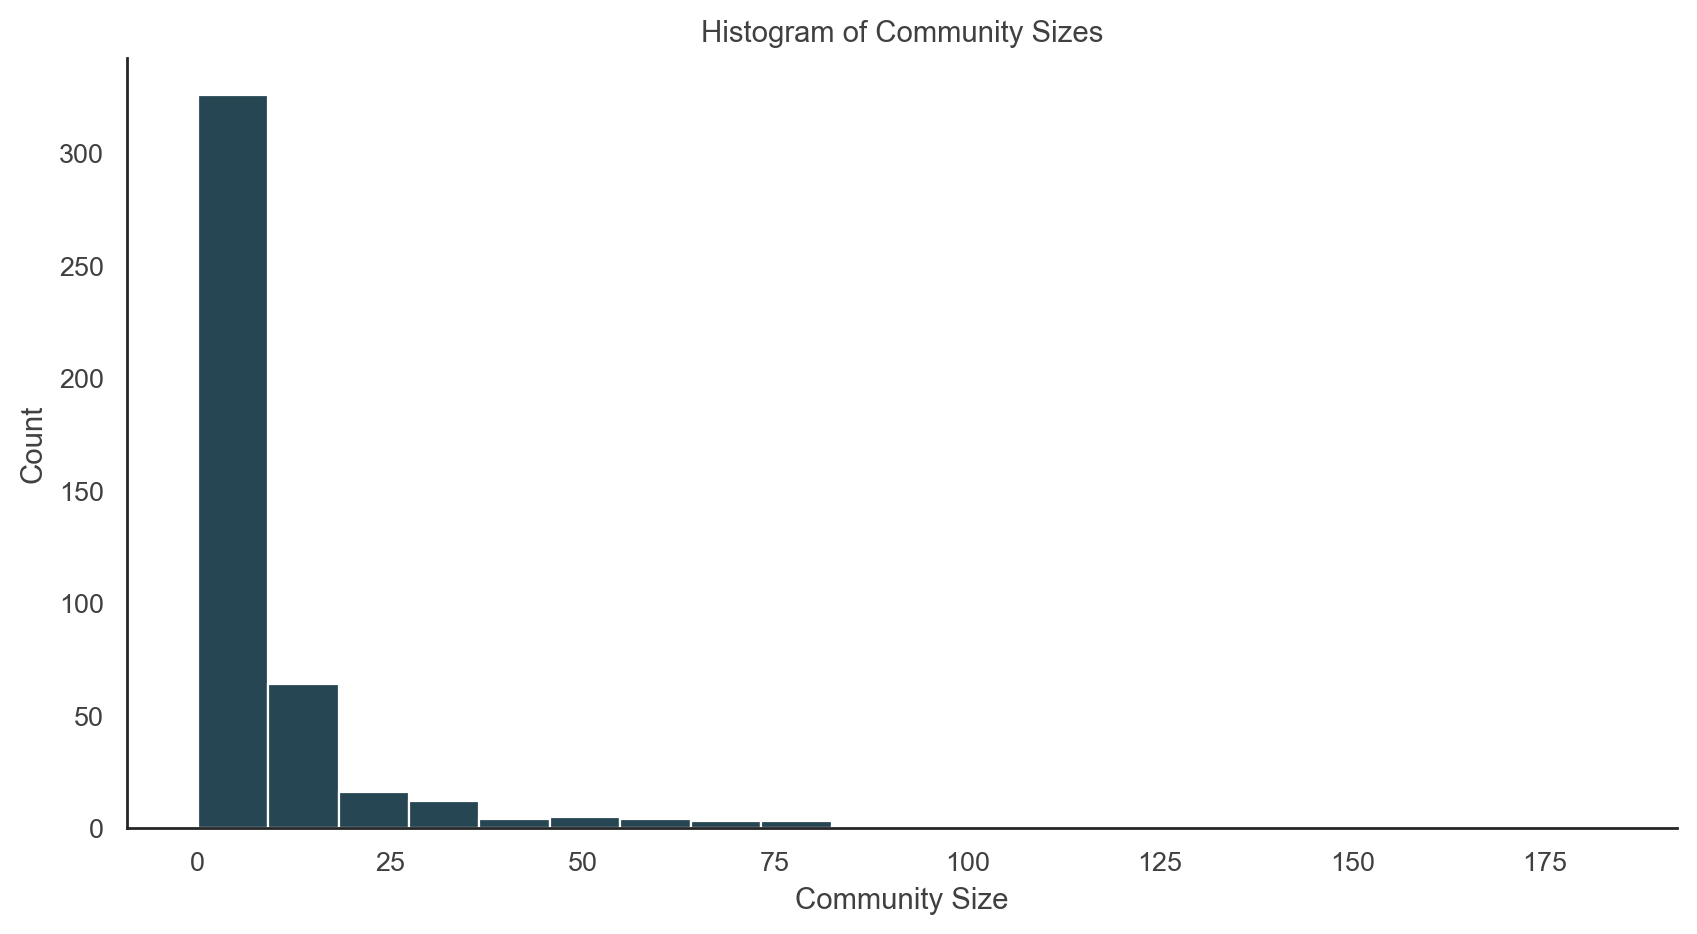

In [245]:
# For each row in the dataframe
for index, row in df.iterrows():
    plt.figure(figsize=(10, 5))
    plt.hist(row, bins=20)
    plt.xlabel('Community')
    plt.ylabel('Count')
    plt.title(f'Histogram for {index}')
    plt.show()

import matplotlib.pyplot as plt

# Flatten the DataFrame into a single series
sizes = df.values.flatten()

# Plot a histogram of the community sizes
plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=20)
plt.xlabel('Community Size')
plt.ylabel('Count')
plt.title('Histogram of Community Sizes')
plt.show()

In [266]:
from src.signet import *

mats, labels = load_data('./data/meneame/synth/deg_corr/')

dfs = []

for w in ['weighted', 'unweighted']:
    df = pd.DataFrame(columns = ['rand', 'ari', 'nmi', 'v_score'], index = titles)
    for i in range(len(mats)):
        label = labels[i]
        scenario = deg_corr_scenarios[i]
        title = titles[i]
        mat = mats[i]
        graph_build = SignedNetwork()
        g = graph_build.graph_construction(repre=mat, repre_type='adj', is_directed=check_if_directed(mat))
        folder = get_folder('meneame',synth = True,scenario= scenario,method='sbm',weighted=True,year=0)
        with open(f'{folder}sbm_not_deg_corr.pkl', 'rb') as f:
            sbm = pickle.load(f)
            print(sbm)
        g.vp['membership'] = g.new_vertex_property(value_type="double", vals=sbm)
        g.vp['labels'] = g.new_vertex_property(value_type="double", vals=label)

        df['rand'][title] = rand_score(list(g.vp['labels']), list(g.vp['membership']))
        df['ari'][title] = adjusted_rand_score(list(g.vp['labels']), list(g.vp['membership']))
        df['nmi'][title] = normalized_mutual_info_score(list(g.vp['labels']), list(g.vp['membership']))
        df['v_score'][title] = v_measure_score(list(g.vp['labels']), list(g.vp['membership']))
    dfs.append(df)

print(dfs)

import pandas as pd

# Initialize an empty dictionary to store the counts
counts_dict = {}

for scenario in deg_corr_scenarios:
    folder = get_folder('meneame',synth = True,scenario= scenario,method='sbm',weighted=True,year=0)
    with open(f'{folder}sbm_not_deg_corr.pkl', 'rb') as f:
        sbm = pickle.load(f)
    labels, counts = np.unique(sbm, return_counts=True)

    # Create a dictionary for the current combination of gamma and lambd
    current_counts = dict(zip(labels, counts))

    # Add the current counts to the overall counts dictionary
    counts_dict[scenario] = current_counts

# Convert the counts dictionary to a DataFrame
df = pd.DataFrame(counts_dict).T

# Set the column names
df.columns = [f'comm. {label}' for label in df.columns]



# Replace NaN values with zeros
df = df.fillna(0)

df = df.astype(int)

[0, 1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 6, 8, 4, 10, 11, 12, 13, 14, 10, 7, 15, 6, 16, 0, 17, 10, 8, 8, 18, 19, 13, 8, 2, 19, 20, 10, 21, 10, 22, 23, 6, 8, 2, 22, 20, 24, 16, 23, 22, 16, 8, 25, 16, 23, 23, 8, 10, 26, 27, 16, 28, 0, 4, 22, 29, 10, 10, 15, 2, 2, 21, 16, 8, 30, 15, 21, 12, 22, 2, 8, 23, 16, 17, 7, 17, 13, 10, 10, 31, 10, 4, 19, 19, 19, 22, 2, 21, 6, 0, 8, 25, 22, 3, 12, 10, 7, 1, 16, 10, 5, 1, 22, 19, 2, 32, 0, 4, 0, 19, 16, 4, 32, 15, 22, 13, 2, 23, 0, 23, 6, 16, 15, 4, 12, 19, 6, 19, 23, 23, 19, 16, 6, 32, 9, 23, 7, 30, 32, 26, 10, 8, 23, 10, 10, 15, 10, 11, 10, 14, 16, 8, 0, 2, 29, 19, 5, 13, 16, 28, 6, 10, 2, 33, 5, 31, 10, 0, 8, 24, 24, 15, 16, 33, 32, 26, 6, 1, 8, 33, 7, 15, 16, 22, 2, 1, 6, 8, 19, 22, 23, 2, 21, 2, 22, 29, 34, 19, 28, 0, 10, 8, 20, 22, 20, 10, 10, 10, 10, 8, 3, 18, 5, 6, 29, 1, 12, 8, 26, 27, 23, 8, 27, 7, 0, 10, 4, 15, 16, 10, 2, 23, 26, 17, 10, 16, 18, 2, 31, 13, 8, 18, 17, 10, 7, 13, 22, 21, 35, 22, 23, 10, 32, 22, 32, 23, 14, 10, 36, 10, 10, 5, 10, 1

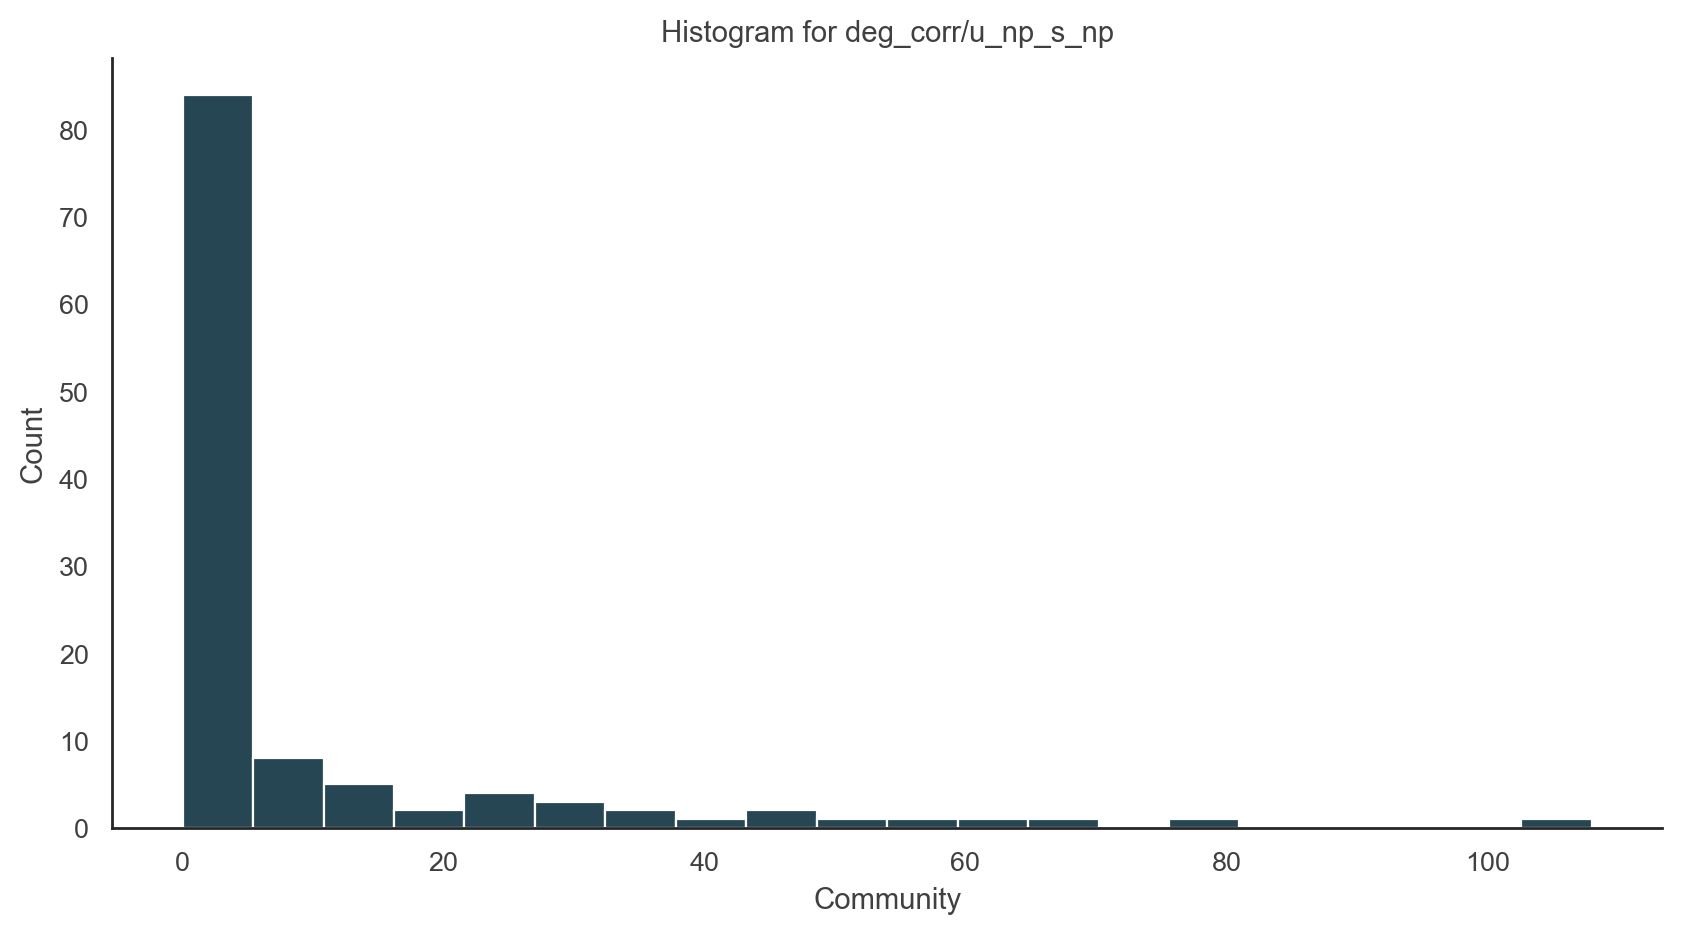

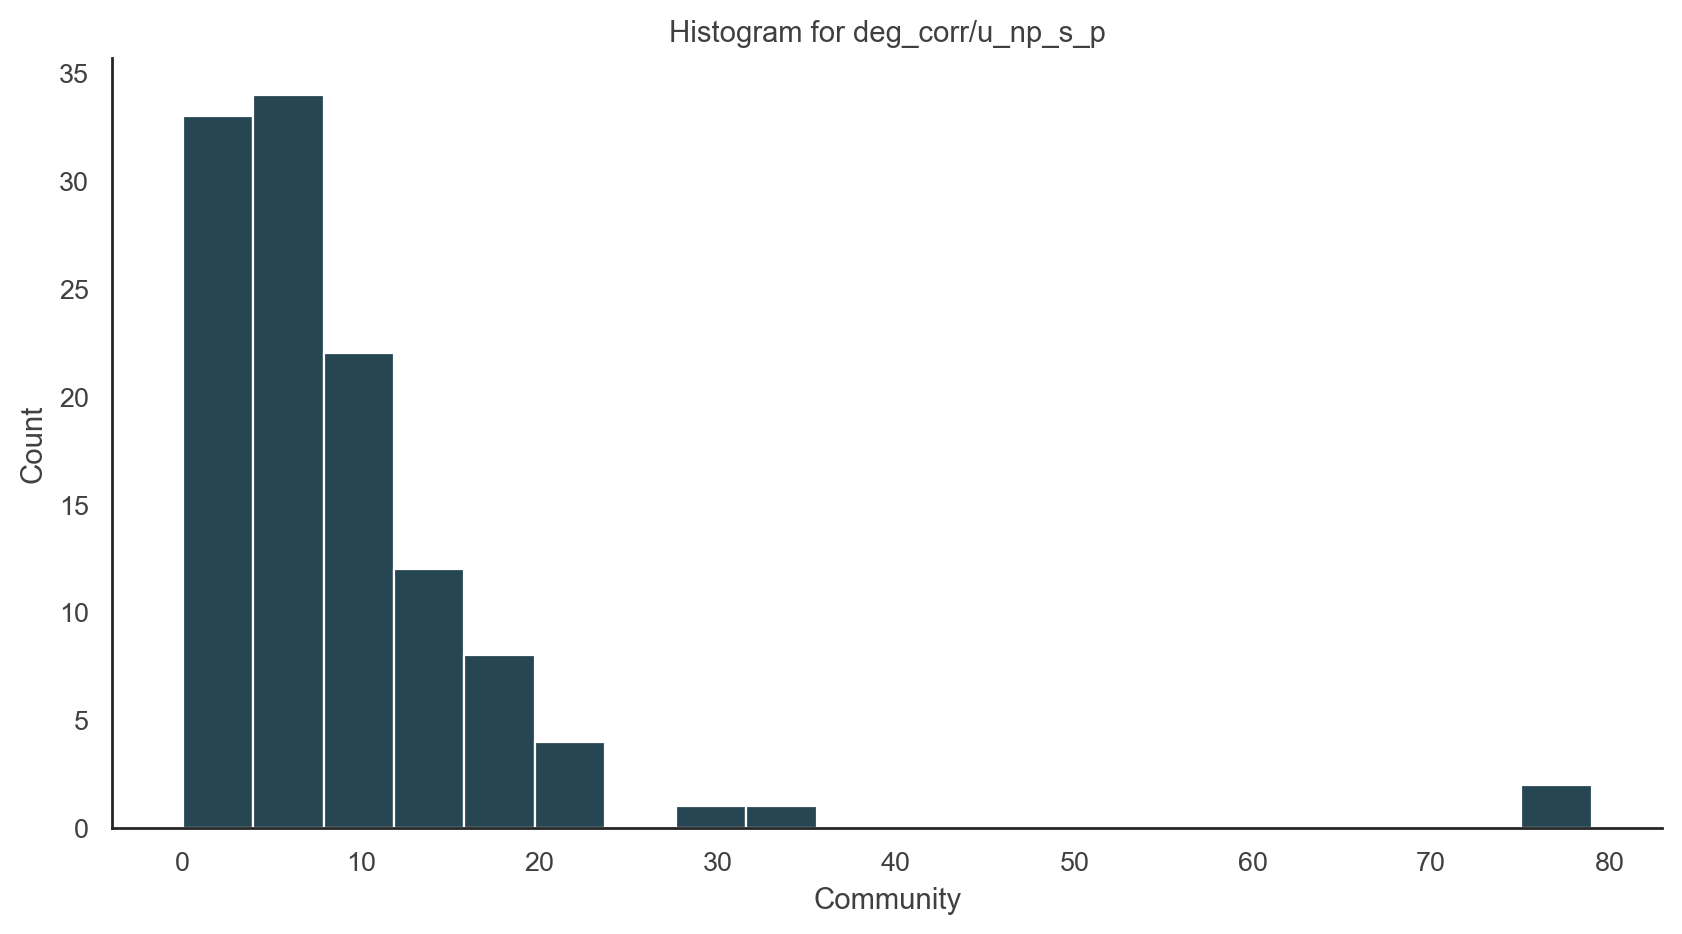

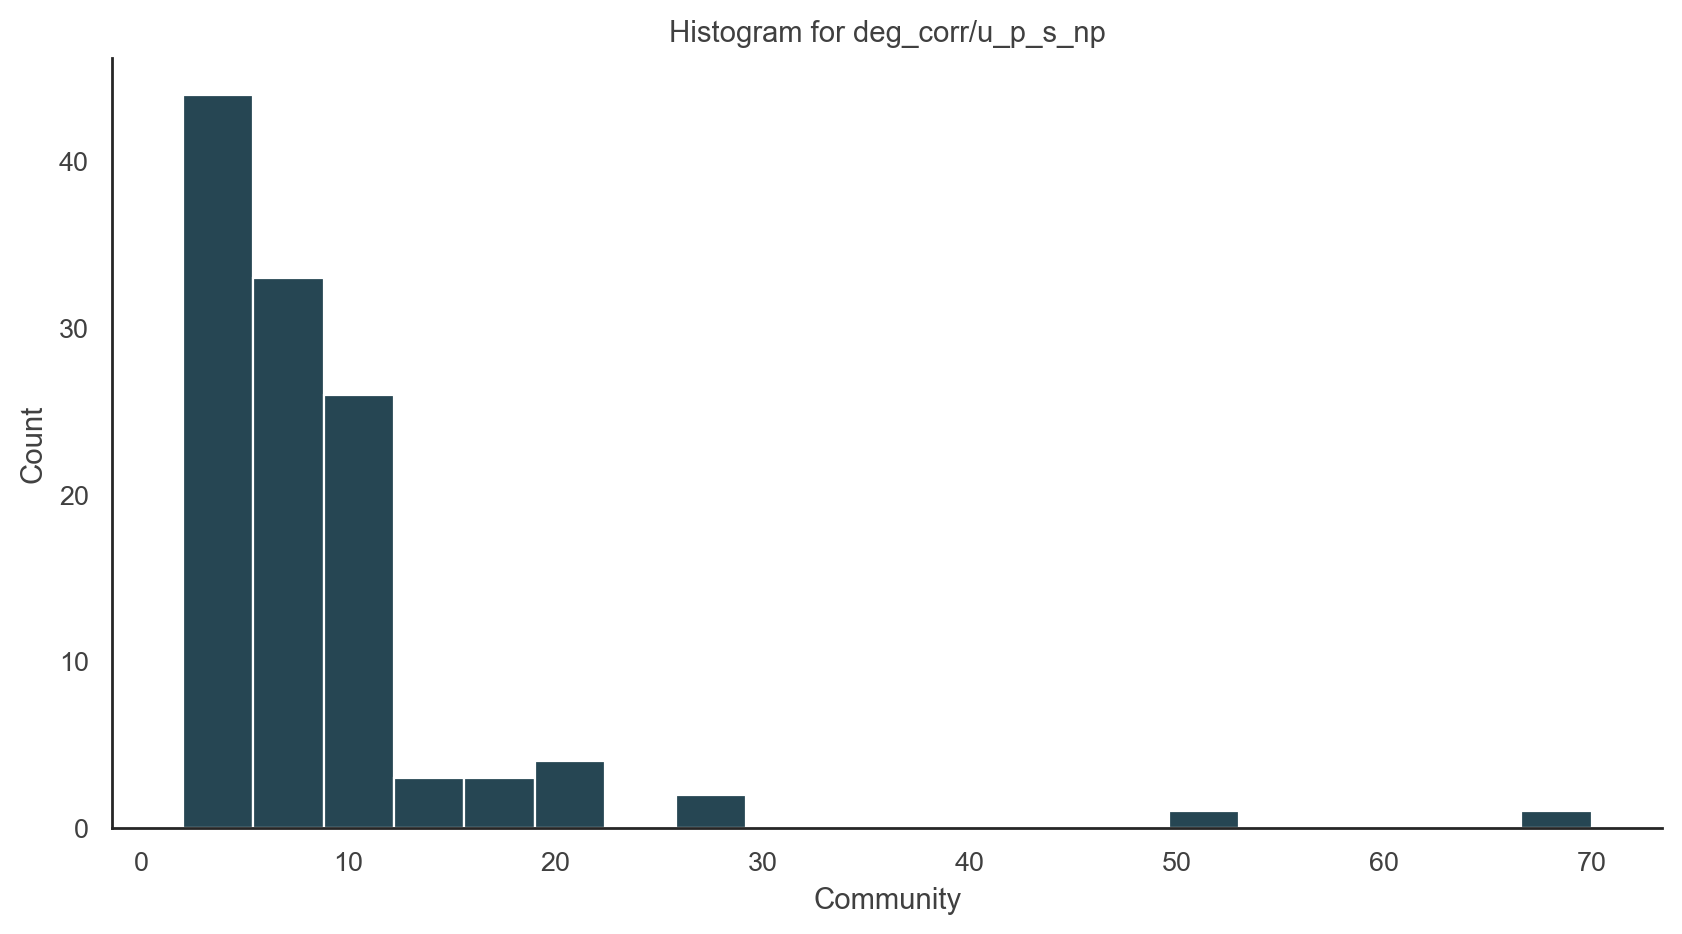

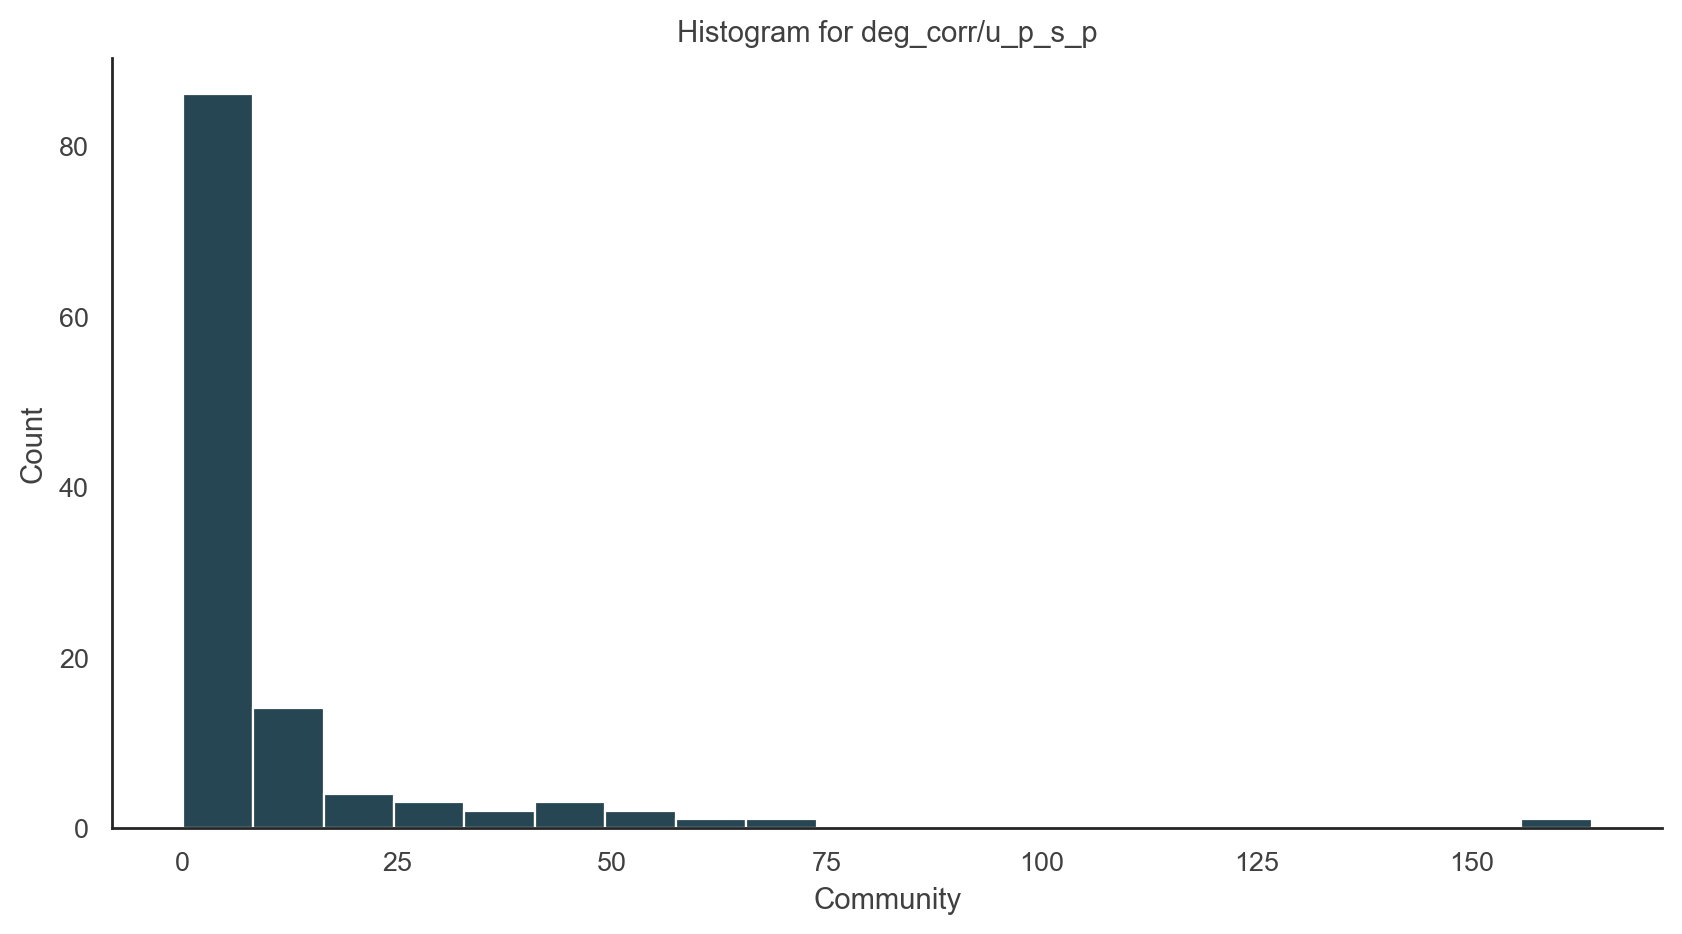

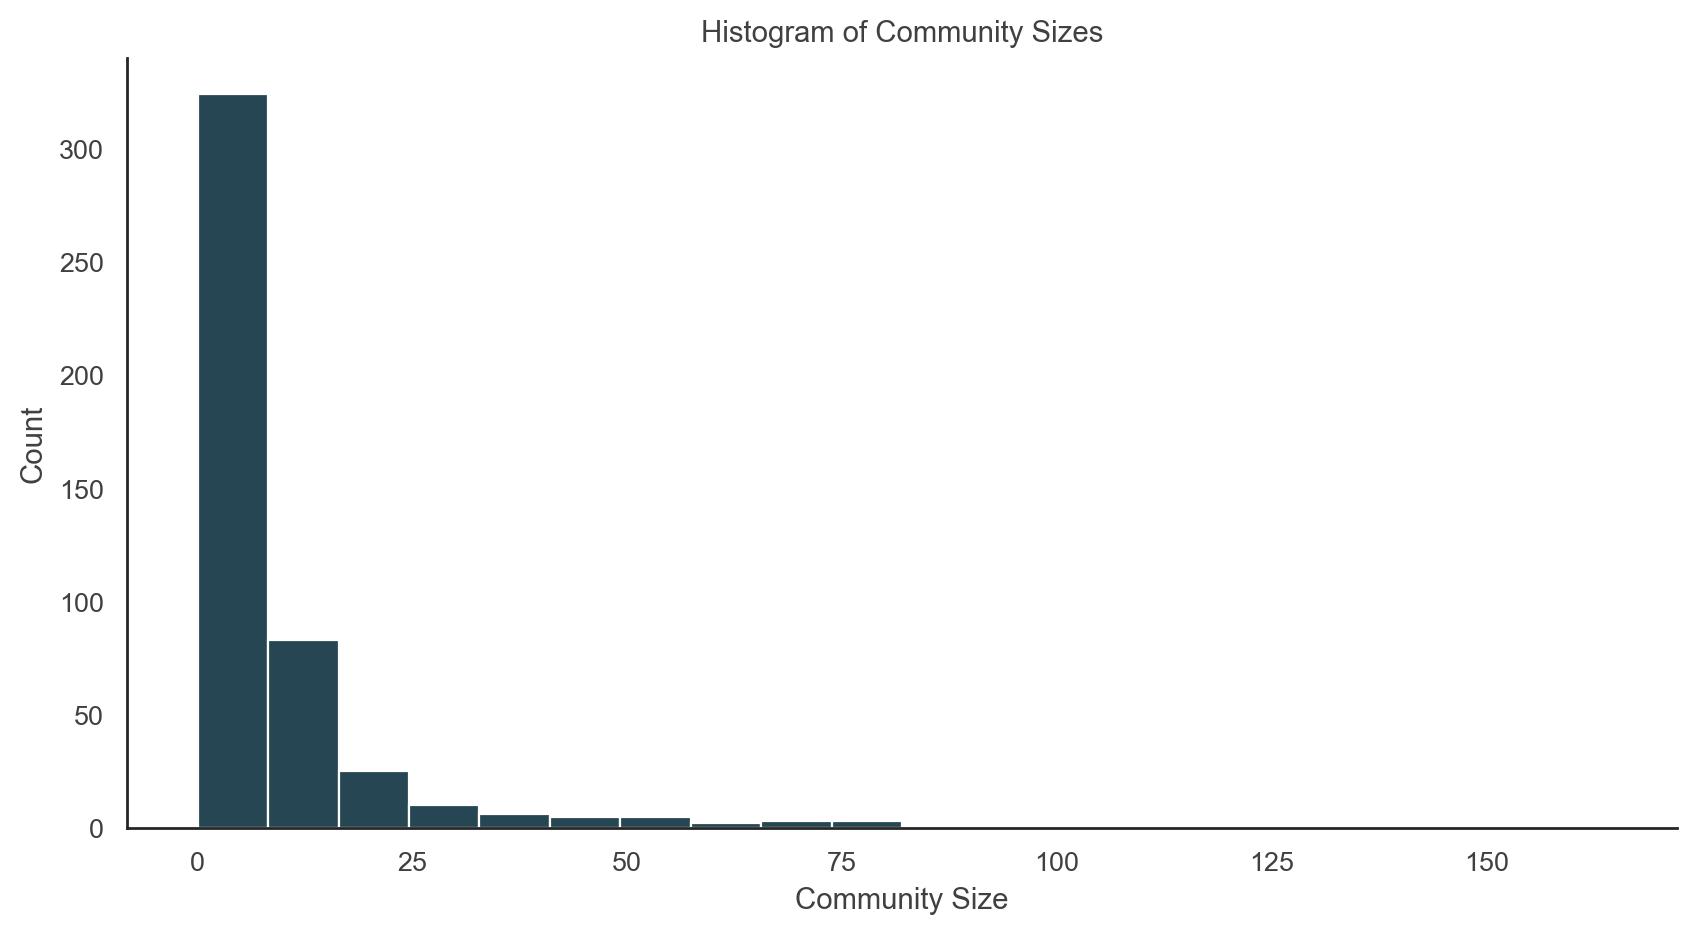

In [267]:
# For each row in the dataframe
for index, row in df.iterrows():
    plt.figure(figsize=(10, 5))
    plt.hist(row, bins=20)
    plt.xlabel('Community')
    plt.ylabel('Count')
    plt.title(f'Histogram for {index}')
    plt.show()

import matplotlib.pyplot as plt

# Flatten the DataFrame into a single series
sizes = df.values.flatten()

# Plot a histogram of the community sizes
plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=20)
plt.xlabel('Community Size')
plt.ylabel('Count')
plt.title('Histogram of Community Sizes')
plt.show()

## Real data

In [268]:
with bz2.BZ2File(f'./data/meneame/real-data/adj_data.pkl', 'r') as f:
    A = pickle.load(f)

### Spinglass

In [269]:
gammas = [0.5, 1]
lambdas = [0.5, 1]

In [270]:
import pandas as pd

# Initialize an empty dictionary to store the counts
counts_dict = {}

for gamma in gammas:
    for lambd in lambdas:
        folder = get_folder('meneame',synth = False,scenario= 'u_np_s_np',method='spinglass',weighted=True,year=0)
        with open(f'{folder}gamma_{gamma}_lambda_{lambd}_run_0.pickle', 'rb') as f:
            spinglass = pickle.load(f)
        labels, counts = np.unique(spinglass, return_counts=True)

        # Create a dictionary for the current combination of gamma and lambd
        current_counts = dict(zip(labels, counts))

        # Add the current counts to the overall counts dictionary
        counts_dict[(gamma, lambd)] = current_counts

# Convert the counts dictionary to a DataFrame
df = pd.DataFrame(counts_dict).T

# Set the column names
df.columns = [f'comm. {label}' for label in df.columns]

# Set the index names
df.index.names = ['$\gamma^+$', '$\gamma^-$']

# Replace NaN values with zeros
df = df.fillna(0)

df = df.astype(int)

df

comm. 0  comm. 1  comm. 2  comm. 3  comm. 4  comm. 5  \
$\gamma^+$ $\gamma^-$                                                         
0.5        0.5            9917      749        1        1        1        1   
           1.0            9970      699        1        0        0        0   
1.0        0.5            5802     1928     2820       32       52       11   
           1.0            5748     2050     2868        1        1        2   

                       comm. 6  comm. 7  comm. 8  comm. 9  comm. 10  comm. 11  \
$\gamma^+$ $\gamma^-$                                                           
0.5        0.5               0        0        0        0         0         0   
           1.0               0        0        0        0         0         0   
1.0        0.5               5        5        2        8         2         2   
           1.0               0        0        0        0         0         0   

                       comm. 12  
$\gamma^+$ $\gamma^-$            
0.5        0.5                0  
           1.0                0  
1.0        0.5                1  
           1.0                0

### SPONGE

In [271]:

# Initialize an empty dictionary to store the counts
counts_dict = {}

for k in range(10):
    folder = get_folder('meneame',synth = False,scenario= 'u_np_s_np',method='sponge',weighted=True,year=0)
    with open(f'{folder}{k+1}_run_{1}.pickle', 'rb') as f:
        sponge = pickle.load(f)
    labels, counts = np.unique(sponge, return_counts=True)

    # Create a dictionary for the current combination of gamma and lambd
    current_counts = dict(zip(labels, counts))

    # Add the current counts to the overall counts dictionary
    counts_dict[k] = current_counts

# Convert the counts dictionary to a DataFrame
df = pd.DataFrame(counts_dict).T

# Set the column names
df.columns = [f'{label}' for label in df.columns]

# Set the index names
df.index.names = ['k']

# Replace NaN values with zeros
df = df.fillna(0)

df = df.astype(int)

df

0     1     2     3     4     5    6    7     8    9
k                                                          
0  11628     0     0     0     0     0    0    0     0    0
1  11591    37     0     0     0     0    0    0     0    0
2  11583     8    37     0     0     0    0    0     0    0
3   7087    37  4496     8     0     0    0    0     0    0
4   7172     8    25    13  4410     0    0    0     0    0
5   7247    25     8    10  4325    13    0    0     0    0
6   7436    13     8    25    10  3471  665    0     0    0
7   3453     8    25  7401    13    10   10  708     0    0
8     25  7412    13     8    10     4   10  687  3459    0
9   3450  7417    10     8    25     4   13   10     8  683

# House of Representatives

## Synthetic networks

TypeError: rand_score_df() got an unexpected keyword argument 'deg_corr'

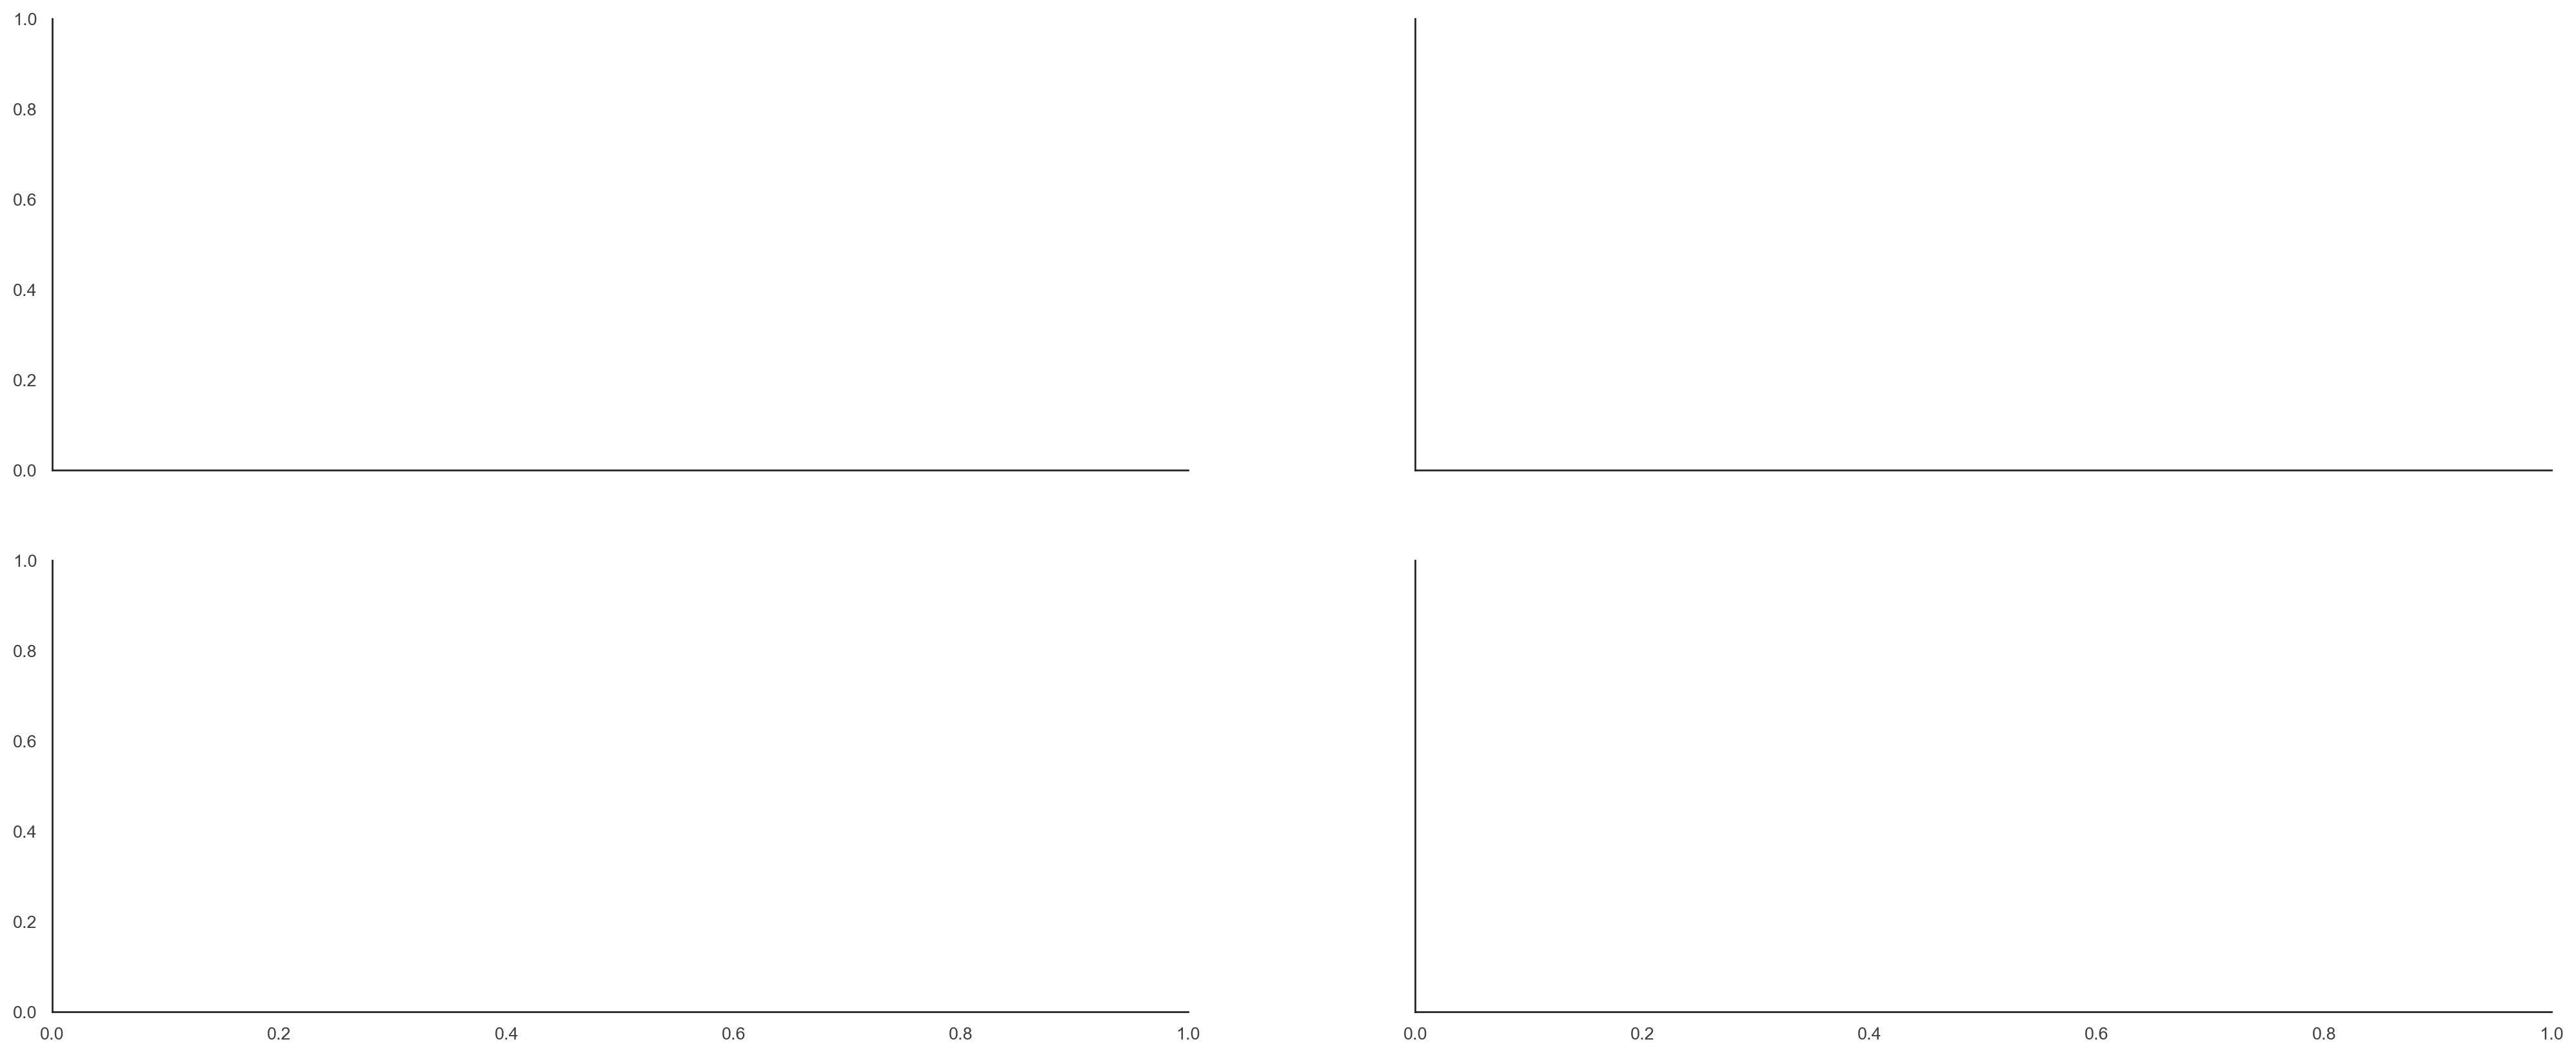

In [278]:
years = np.arange(1990,2023)
gammas = [0.5, 1, 2]
lambdas = [0.5, 1, 2]
titles = ['U NP\nS NP',  'U NP\nS  P', 'U  P\nS NP','U  P\nS  P']


for year in years:
    mats, labels = load_data(f'./data/us-house/synth/{year}/uniform/')
    fig, axs = plt.subplots(2, 2,figsize = (25,10), dpi =200, sharey=True, sharex = True)
    j = 0
    
    for m, ax in zip(measures, axs.ravel()):
        dfs = rand_score_df('spinglass', mats, labels, deg_corr=False, metrics=m, year = year, clerk=True)
        plot_spinglass_synth(ax, dfs[::2], lambdas, gammas, titles, text_size)
        ax.set_ylabel(measures_labels[j], size =text_size)
        j+=1

    fig.suptitle(f'Community-spinglass (year {year})', size = text_size)
    plt.tight_layout()
    create_directory(f'./plots/spinglass/clerk/{year}/')
    create_directory(f'{dropbox_folder}plots/spinglass/clerk/{year}/')
    plt.savefig(f'./plots/spinglass/clerk/{year}/metrics_comparison.pdf')
    plt.savefig(f'{dropbox_folder}plots/spinglass/clerk/{year}/metrics_comparison.pdf')
    plt.show()

    fig, axs = plt.subplots(2, 2,figsize = (25,10), dpi =200, sharey=True, sharex = True)

    j = 0
    for m, ax in zip(measures, axs.ravel()):
        df, df_std = rand_score_df(method='sponge',dataset='us-house',mats= mats, scenarios=uniform_scenarios,labels=labels,synth=True, metrics=m)

        plot_sponge_synth(ax, df, df_std, text_size)
        ax.set_ylabel(measures_labels[j], fontsize =text_size)
        j+=1

    fig.suptitle(f'SPONGE (year {year})', size = text_size)
    plt.tight_layout()
    create_directory(f'./plots/sponge/clerk/{year}/')
    create_directory(f'{dropbox_folder}plots/sponge/clerk/{year}/')
    plt.savefig(f'./plots/sponge/clerk/{year}/metrics_comparison.pdf')
    plt.savefig(f'{dropbox_folder}plots/sponge/clerk/{year}/metrics_comparison.pdf')


## Real Data

In [304]:
# Load matrices
path_adj = f'./data/us-house/real-data/adj/'

path_labels = f'./data/us-house/real-data/label/'
years = np.arange(1990,2023)
mats = [pickle.load(open(path_adj + f, 'rb')) for f in [f'{year}.pkl' for year in years]]
labels = [pickle.load(open(path_labels + f, 'rb')) for f in [f'{year}.pkl' for year in years]]
scenarios = list(np.arange(1990,2023))
titles = [str(x) for x in np.arange(1990,2023)]

### Spinglass

In [301]:
gammas = [0.5, 1, 2]
lambdas = [0.5, 1, 2]


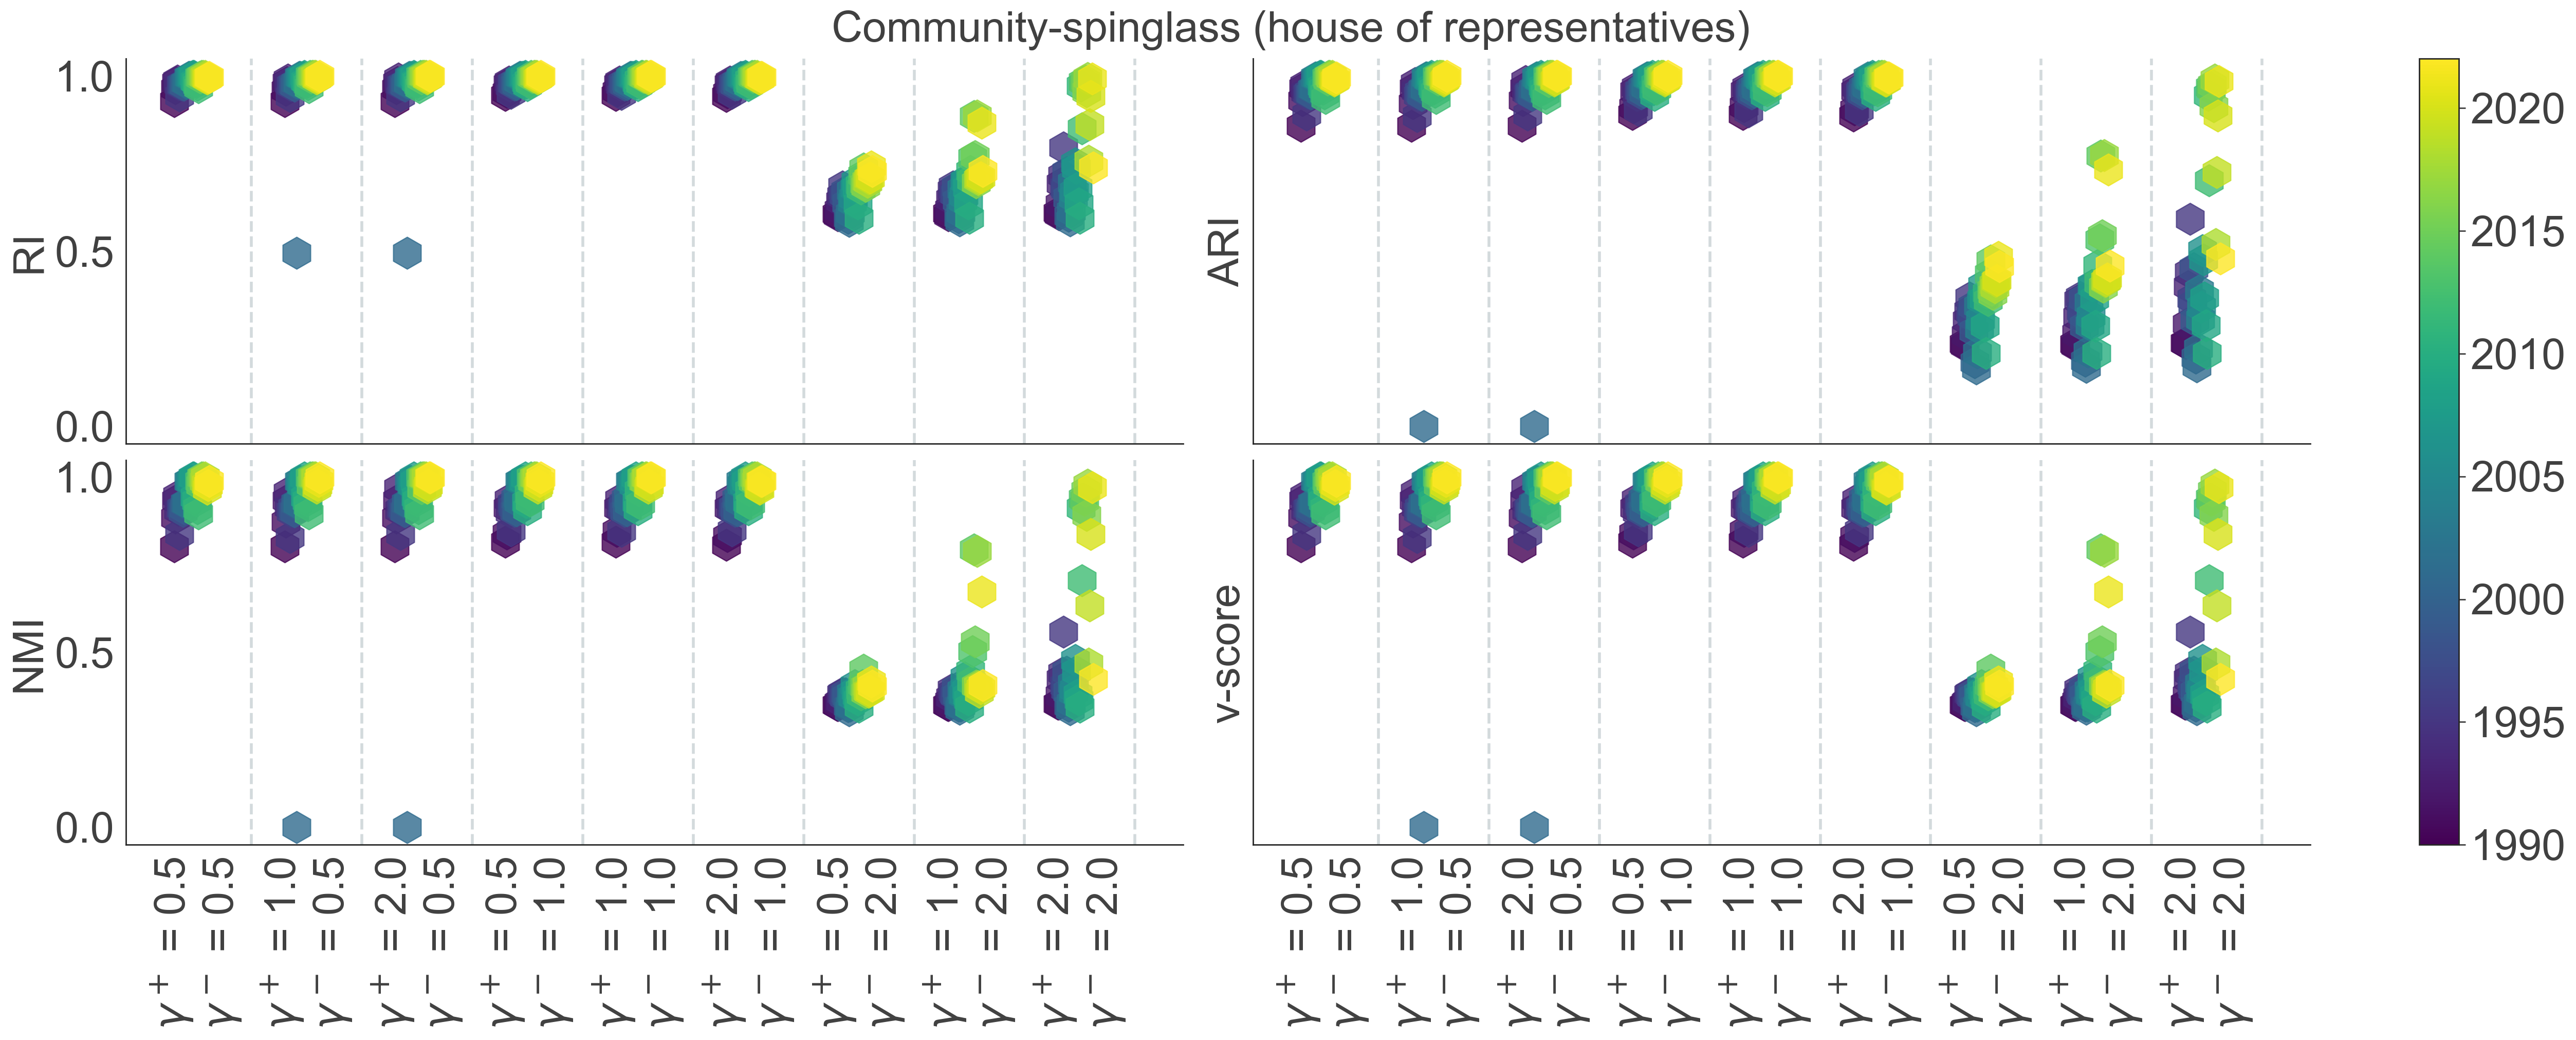

In [302]:
# Create a ScalarMappable object with the same colormap and normalization
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=mcolors.Normalize(vmin=min(years), vmax=max(years)))
sm.set_array([])  # You can set a dummy array

fig, axs = plt.subplots(2, 2,figsize = (25,10), dpi =200, sharey=True, sharex = True, constrained_layout=True)

j = 0
for m, ax in zip(measures, axs.ravel()):

    dfs = rand_score_df(method='spinglass',dataset='us-house',mats= mats, labels=labels, scenarios=scenarios,synth=False, metrics=m, year =scenarios)
    weighted_dfs = dfs[::2]
    unweighted_dfs = dfs[1::2]


    # Generate a Viridis palette with 33 colors
    colors = cm.viridis(np.linspace(0, 1, 33))

    # Map years to colors
    year_to_color = {year: color for year, color in zip(sorted(years), colors)}

    x = 0
    ticks = []
    for lambd in lambdas:
        for gamma in gammas:
            delta = 0

            for i, df in enumerate(weighted_dfs):
                # Get the color for the current year
                color = year_to_color[years[i]]
                
                ax.scatter(x+delta, df.at[gamma, lambd], s = 500, marker = 'h', color=color, alpha = 0.8)
                delta += 0.01

            ticks.append(f'$\gamma^+$ = {gamma:.1f}\n$\gamma^-$ = {lambd:.1f}')
            ax.axvline(x+0.7, ls='--', alpha =0.2)
            x +=1
    ax.set_xticks([i+0.2 for i in range(x)],ticks, fontsize=text_size, rotation =90)
    ax.tick_params(axis='y', labelsize=text_size)
    ax.set_ylabel(measures_labels[j], size =text_size)
    j +=1

# Add the colorbar to the figure
cbar = fig.colorbar(sm,  ax=axs.ravel().tolist())
cbar.ax.tick_params(labelsize=text_size)  # Set the tick size
fig.suptitle('Community-spinglass (house of representatives)', size = text_size)
#plt.tight_layout()
#adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

save_plot('./plots/spinglass/us-house/', filename = 'metrics_comparison.pdf')
plt.show()

### SPONGE

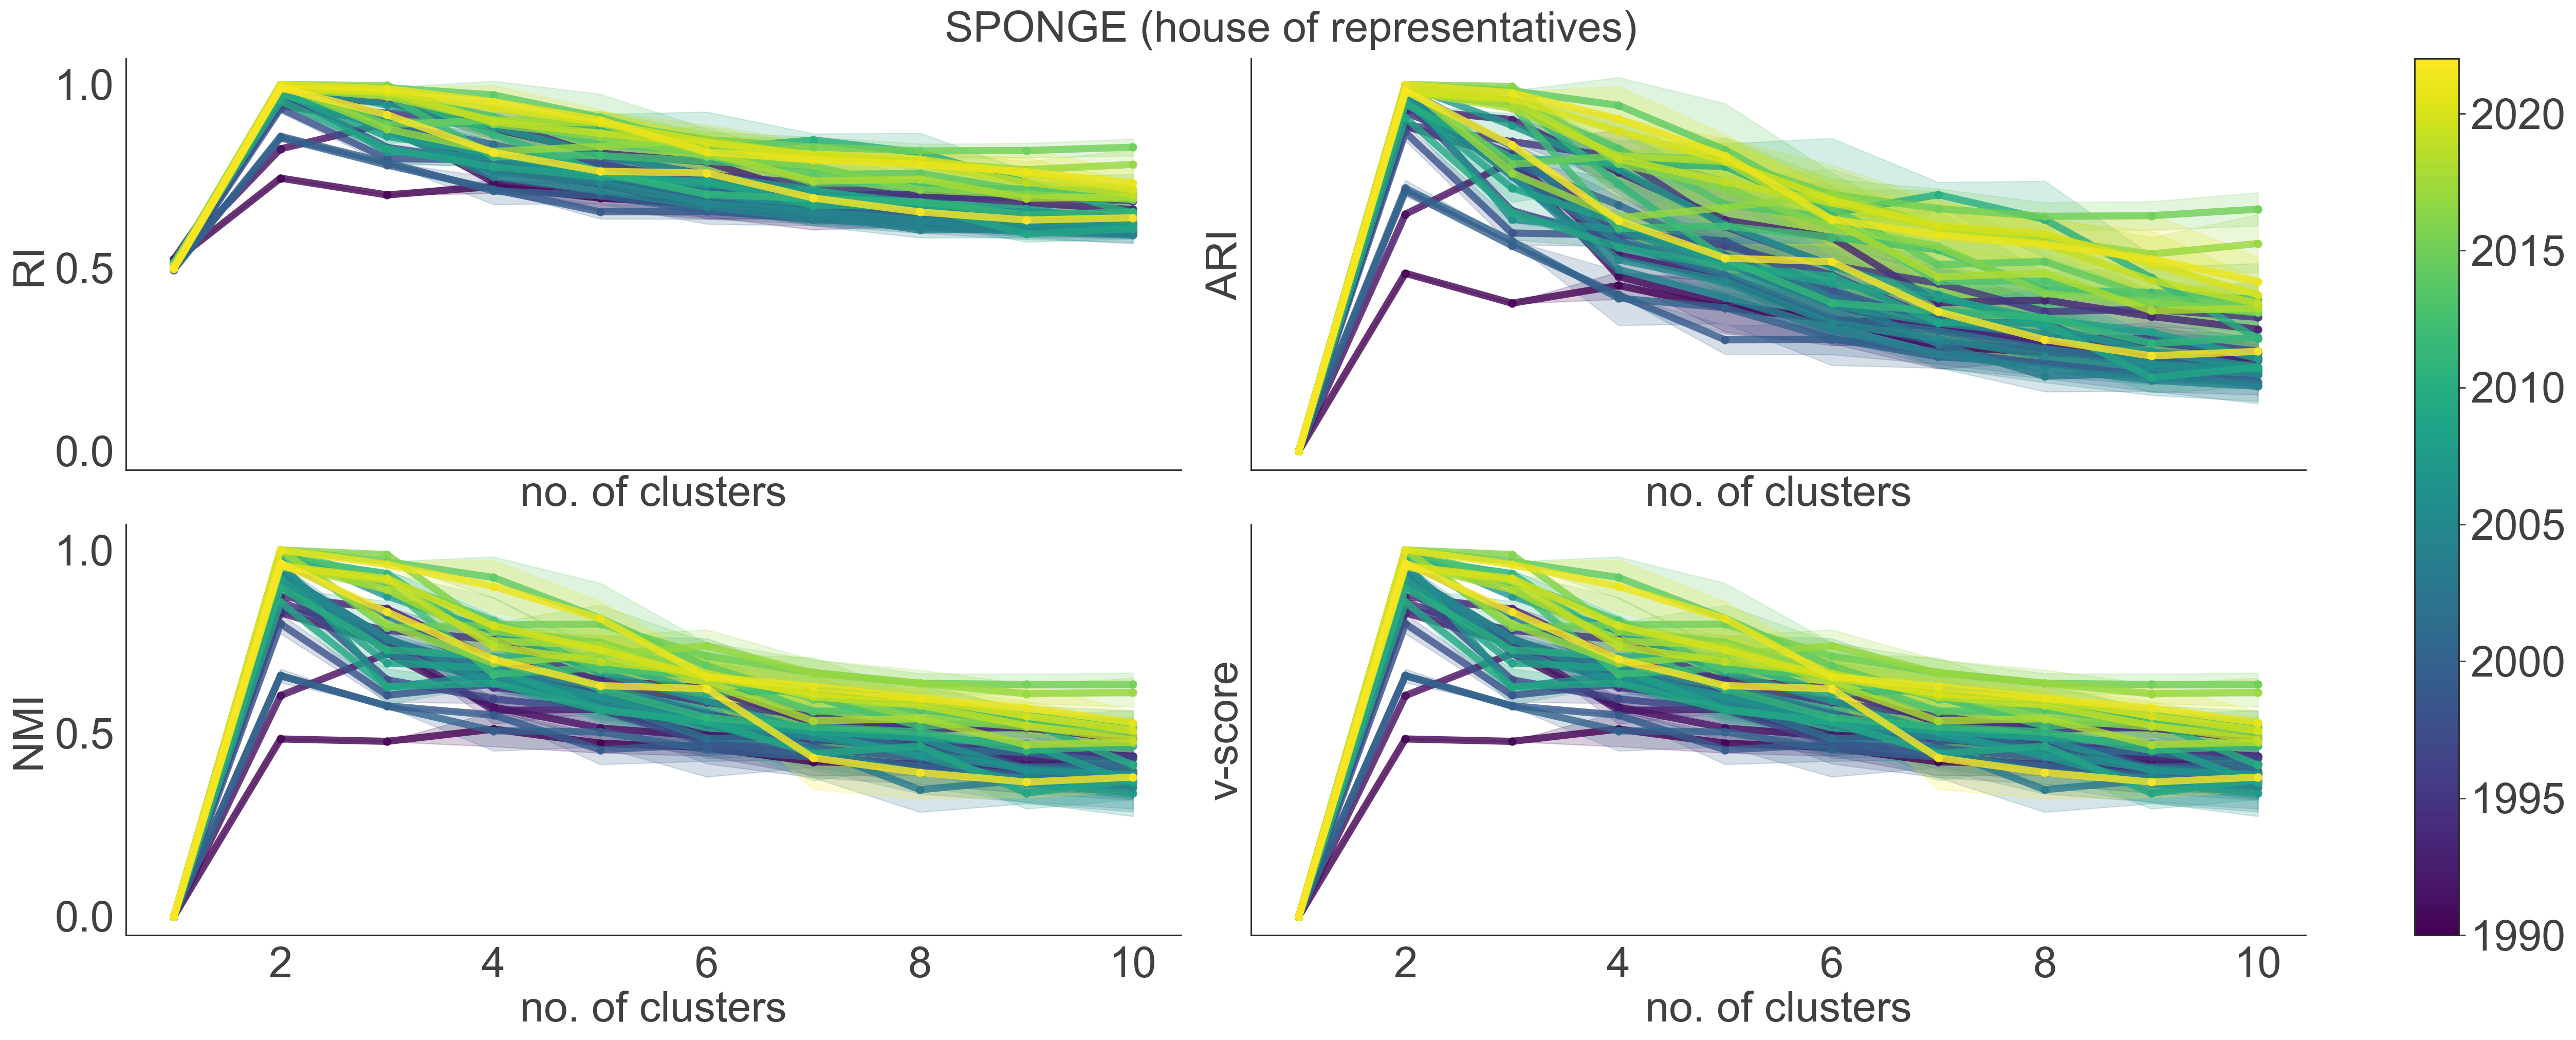

In [306]:
# Create a ScalarMappable object with the same colormap and normalization
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=mcolors.Normalize(vmin=min(years), vmax=max(years)))
sm.set_array([])  # You can set a dummy array

fig, axs = plt.subplots(2, 2,figsize = (25,10), dpi =200, sharey=True, sharex = True, constrained_layout=True)

j = 0
for m, ax in zip(measures, axs.ravel()):
    df, df_std = rand_score_df(method='sponge',dataset='us-house',mats= mats, scenarios=scenarios,year=scenarios,labels=labels,synth=False, titles=titles,metrics=m)
    
    x = df.T.index.tolist()
    mean = df.T.values.tolist()
    std = df_std.T.values.tolist()

    # Map labels to colors
    label_to_color = {label: color for label, color in zip(df.T.columns, colors)}

    for label, m, s in zip(df.T.columns, np.array(mean).T, np.array(std).T):
        m = np.array(m)
        s = np.array(s)
        # Use the color for the current label
        color = label_to_color[label]
        ax.plot(x, m, label=label, marker='o', markersize=5, linestyle='-', linewidth=5, color=color,  alpha = 0.8)
        ax.fill_between(x, m-s, m+s, alpha=0.2, color=color, interpolate=True)

    #ax.scatter(x = 1, y = 1, s = 70, marker = 'x', c = '#219ebc', zorder=3, label = 'exp. value\nusers pol.')
    #ax.scatter(x = 2, y = 1, s = 70, marker = 'x', c = '#bc6c25', zorder=3, label = 'exp. value\nusers not pol.')

    ax.set_ylabel(measures_labels[j], fontsize =text_size)
    ax.set_xlabel('no. of clusters', fontsize =text_size)
    ax.tick_params(axis='both', labelsize=text_size)

    j+=1
    '''
    # Create a ScalarMappable object with the same colormap and normalization
    sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=mcolors.Normalize(vmin=min(df.T.columns), vmax=max(df.T.columns)))

    # Add the colorbar to the plot
    cbar = fig.colorbar(sm, ax=ax)
    cbar.ax.tick_params(labelsize=text_size)  # Set the tick size
    '''
# Add the colorbar to the figure
cbar = fig.colorbar(sm,  ax=axs.ravel().tolist())
cbar.ax.tick_params(labelsize=text_size)  # Set the tick size
fig.suptitle('SPONGE (house of representatives)', size = text_size)
save_plot('./plots/sponge/us-house/', filename = 'metrics_comparison.pdf')
plt.show()

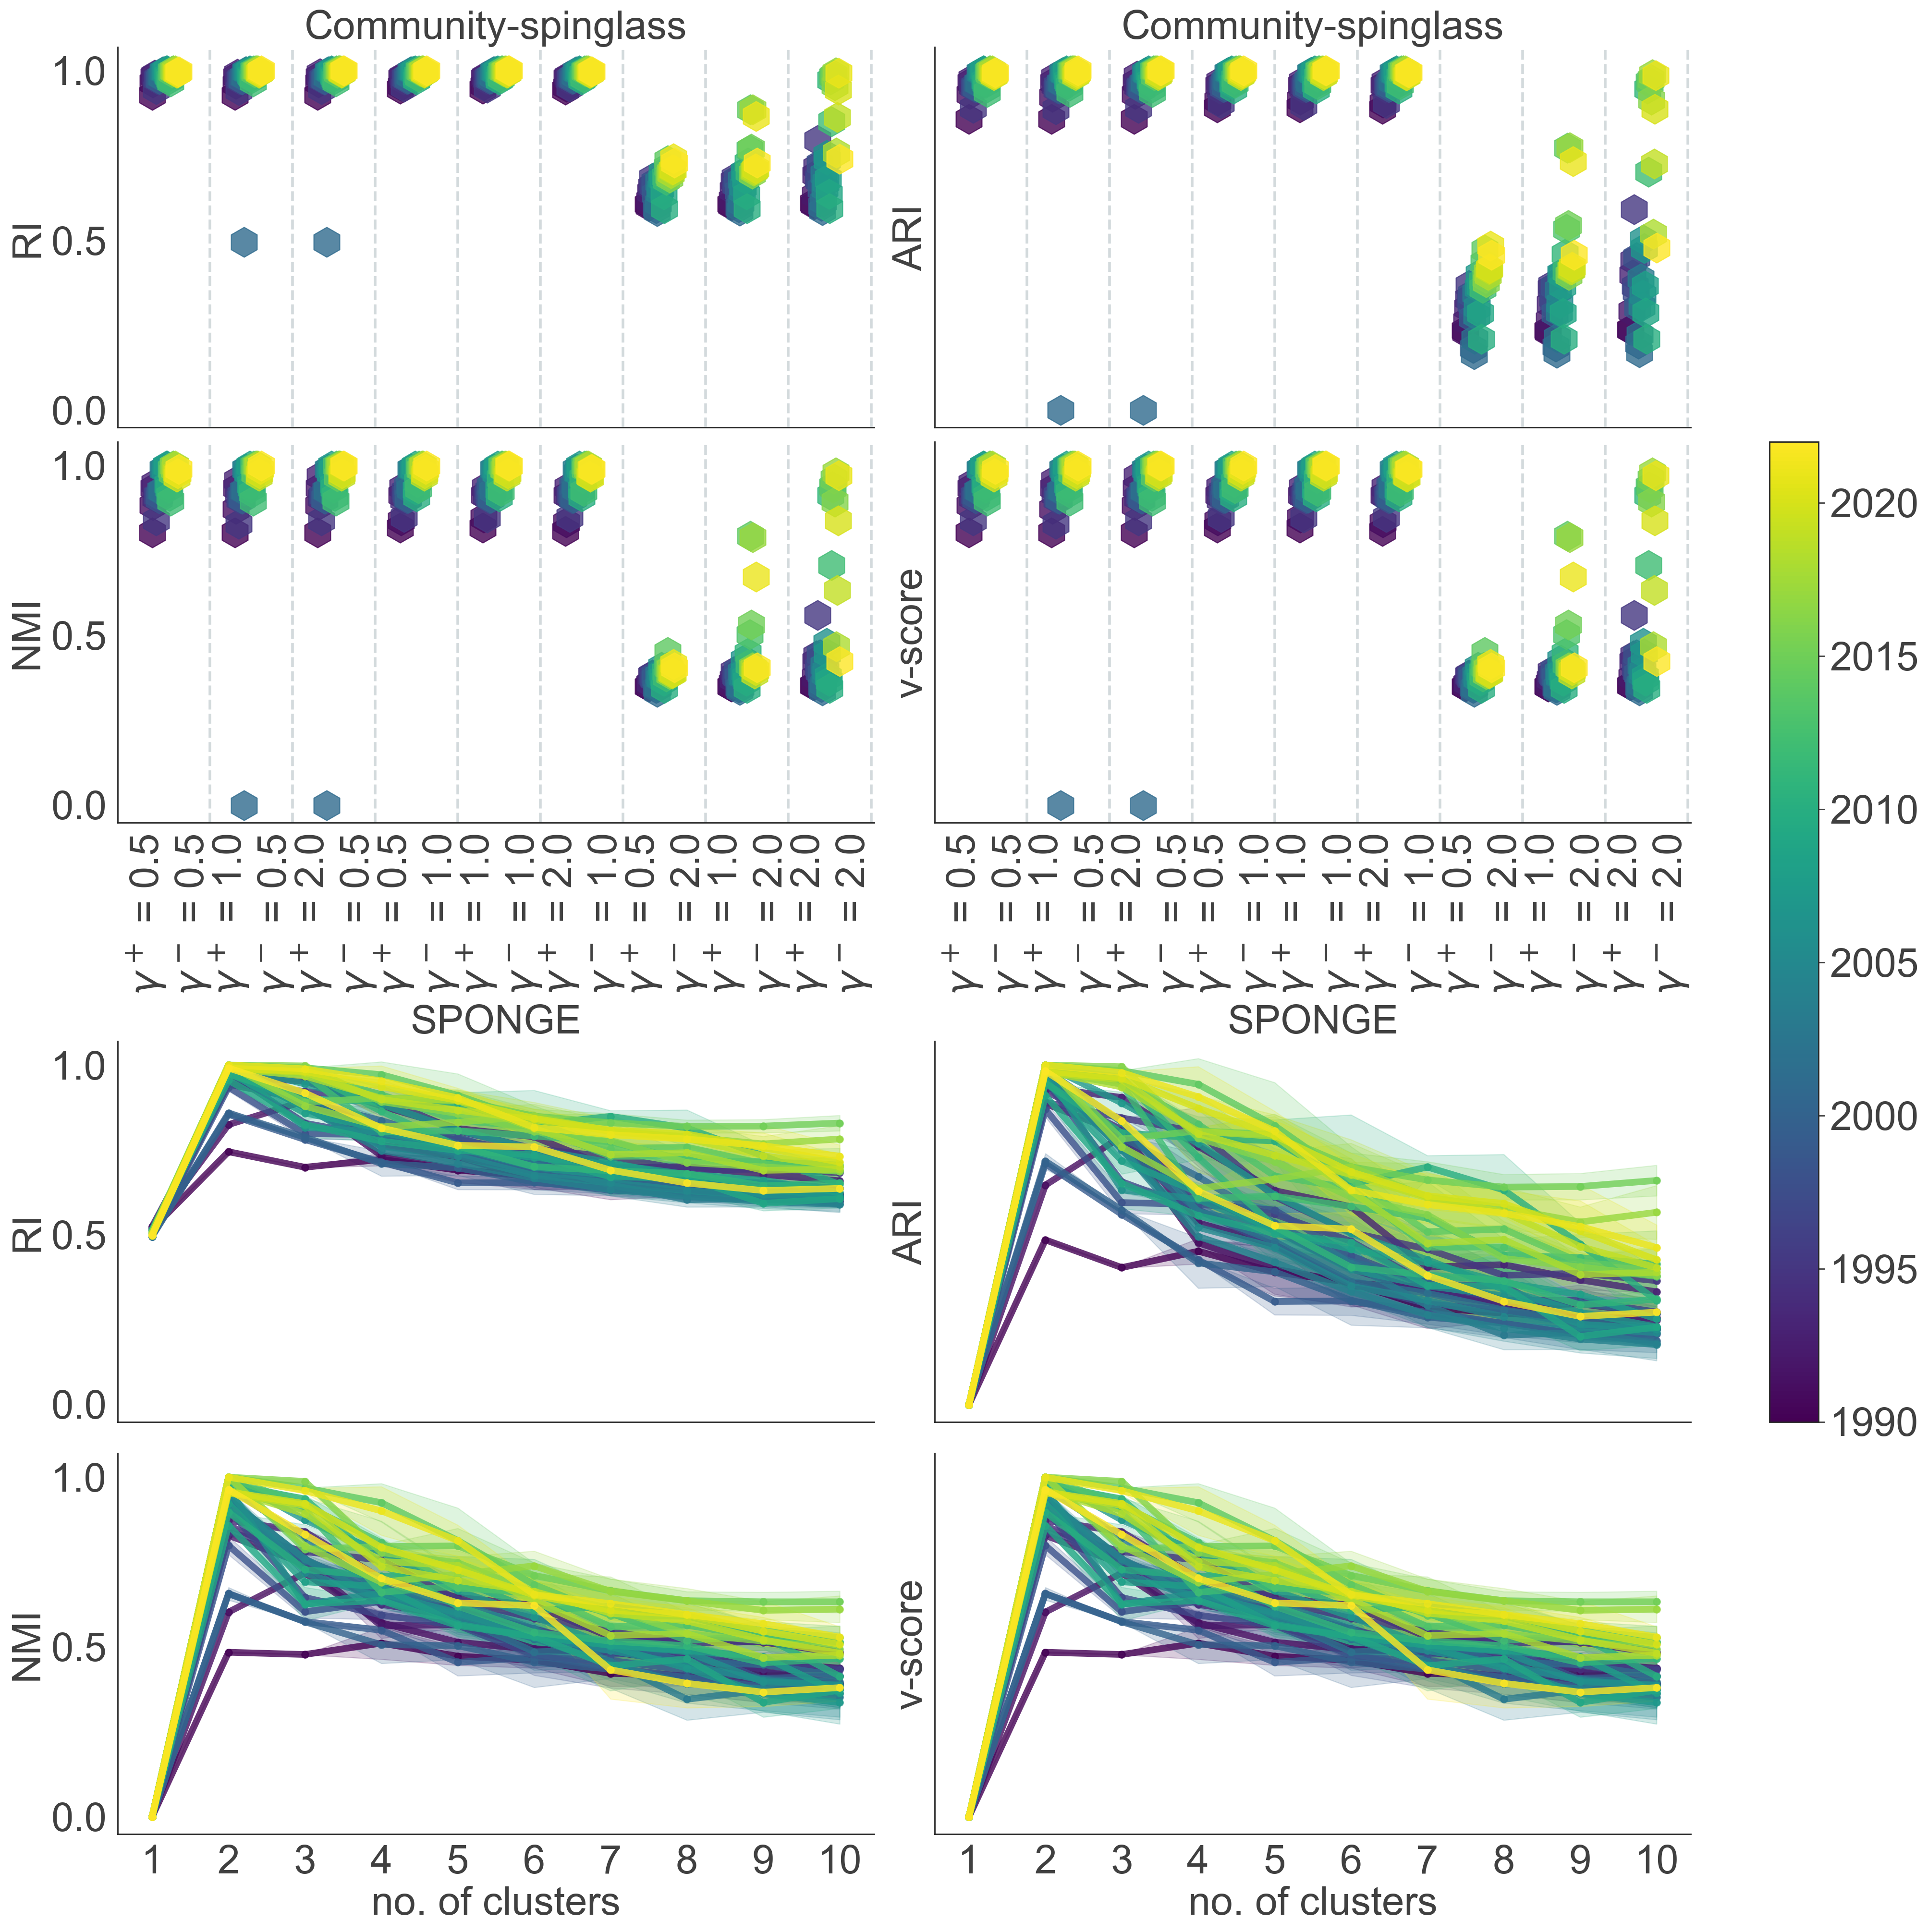

In [307]:
# Create a ScalarMappable object with the same colormap and normalization
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=mcolors.Normalize(vmin=min(years), vmax=max(years)))
sm.set_array([])  # You can set a dummy array

fig, axs = plt.subplots(4, 2, figsize = (20,20),dpi =200, sharey=True, constrained_layout=True)

j = 0
for m, ax in zip(measures+measures, axs.ravel()):

    if j < 4:
        dfs = rand_score_df(method='spinglass',dataset='us-house',mats= mats, labels=labels, titles=titles, scenarios=scenarios, year=scenarios,synth=False, metrics=m)
        weighted_dfs = dfs[::2]
        unweighted_dfs = dfs[1::2]

        # Generate a Viridis palette with 33 colors
        colors = cm.viridis(np.linspace(0, 1, 33))

        # Map years to colors
        year_to_color = {year: color for year, color in zip(sorted(years), colors)}

        x = 0
        ticks = []
        for lambd in lambdas:
            for gamma in gammas:
                delta = 0

                for i, df in enumerate(weighted_dfs):
                    # Get the color for the current year
                    color = year_to_color[years[i]]
                    ax.scatter(x+delta, df.at[gamma, lambd], s = 500, marker = 'h', color=color, alpha = 0.8)
                    delta += 0.01

                ticks.append(f'$\gamma^+$ = {gamma:.1f}\n$\gamma^-$ = {lambd:.1f}')
                ax.axvline(x+0.7, ls='--', alpha =0.2)
                x +=1
        if j == 0 or j == 1:
            ax.set_title(f'Community-spinglass', size = text_size)
            ax.set_xticks([])
        else:
            ax.set_xticks([i+0.2 for i in range(x)],ticks, fontsize=text_size, rotation =90)

        ax.tick_params(axis='y', labelsize=text_size)
        ax.set_ylabel((measures_labels+measures_labels)[j], size =text_size)

    else:
        df, df_std = rand_score_df(method='sponge',dataset='us-house',mats= mats, scenarios=scenarios,year=scenarios,labels=labels,synth=False, titles=titles,metrics=m)
        x = df.T.index.tolist()
        mean = df.T.values.tolist()
        std = df_std.T.values.tolist()

        # Map labels to colors
        label_to_color = {label: color for label, color in zip(df.T.columns, colors)}

        for label, m, s in zip(df.T.columns, np.array(mean).T, np.array(std).T):
            m = np.array(m)
            s = np.array(s)
            # Use the color for the current label
            color = label_to_color[label]
            ax.plot(x, m, label=label, marker='o', markersize=5, linestyle='-', linewidth=5, color=color,  alpha = 0.8)
            ax.fill_between(x, m-s, m+s, alpha=0.2, color=color, interpolate=True)
        
        if j == 4 or j == 5:
            ax.set_title(f'SPONGE', size = text_size)
            ax.set_xticks([])
        else:
            ax.set_xlabel('no. of clusters', fontsize =text_size)
            ax.set_xticks(x, x, fontsize=text_size)

        #ax.scatter(x = 1, y = 1, s = 70, marker = 'x', c = '#219ebc', zorder=3, label = 'exp. value\nusers pol.')
        #ax.scatter(x = 2, y = 1, s = 70, marker = 'x', c = '#bc6c25', zorder=3, label = 'exp. value\nusers not pol.')

        ax.set_ylabel((measures_labels+measures_labels)[j], fontsize =text_size)
        ax.tick_params(axis='both', labelsize=text_size)
    j +=1


# Add the colorbar to the figure
cbar = fig.colorbar(sm,  ax=axs.ravel().tolist()[2:5])
cbar.ax.tick_params(labelsize=text_size)  # Set the tick size

save_plot(path = './plots/us-house/', filename = 'metrics_comparison.pdf')
plt.show()

In [108]:
# Load matrices
path_adj = './clerk_data/adj/'
path_labels = './clerk_data/label/'
years = np.arange(1990,2023)
mats = [pickle.load(open(path_adj + f, 'rb')) for f in [f'{year}.pkl' for year in years]]
labels = [pickle.load(open(path_labels + f, 'rb')) for f in [f'{year}.pkl' for year in years]]
scenarios = np.arange(1990,2023)
titles = [str(x) for x in np.arange(1990,2023)]

In [112]:
import pandas as pd

# Initialize an empty dictionary to store the counts
counts_dict = {}

for scenario in scenarios:
    with open(f'./results/sbm/clerk/unweighted/{scenario}/sbm.pkl', 'rb') as f:
        sbm = pickle.load(f)
    labels, counts = np.unique(sbm, return_counts=True)

    # Create a dictionary for the current combination of gamma and lambd
    current_counts = dict(zip(labels, counts))

    # Add the current counts to the overall counts dictionary
    counts_dict[scenario] = current_counts

# Convert the counts dictionary to a DataFrame
df = pd.DataFrame(counts_dict).T

# Set the column names
df.columns = [f'comm. {label}' for label in df.columns]



# Replace NaN values with zeros
df = df.fillna(0)

df = df.astype(int)


In [113]:
df

comm. 0  comm. 1  comm. 2  comm. 3  comm. 4  comm. 5  comm. 6  comm. 7  \
1990       34       21       24       53       19       17        6       51   
1991       30       42       24       12       26       36       31       28   
1992       65       85       12       44       16       41       26       22   
1993       90       65       13       48       14       29       80       48   
1994       59       34       35       24       13       33       47       24   
1995       85      149       11       10       75       60        5        3   
1996       41       26       45       15       64       31       26       29   
1997       22        9       43       28       39       37       15       20   
1998       28       32       55       14       13       41       47       29   
1999       14       21       28       19       20       23       74       24   
2000       49       19       33       35       14       21       83       38   
2001       93       61       72       13       26       63        9       35   
2002       21       32        7       15       84       28       37        7   
2003       16       17       40       19       37       26       15       36   
2004       18       22       19       51       24       17       26       18   
2005       16       31       26       36       15       45       24       23   
2006       28       39       31       28       23       15       40       27   
2007       35       70       19       81        9        5       37       16   
2008       79       52       18       34        9       18       31       58   
2009       49       64        8       12       18       16       67        9   
2010       61      181      161        4       30        5        2        2   
2011      175       92       80       71        5        2        5        2   
2012      170      121       93        4        7       10       19        4   
2013      190       42      185        4        3        9        3        2   
2014      189      194       39        3        4        3        5        1   
2015      213      187        4        2       38        1        0        0   
2016      225      183        4        2       21        2        1        0   
2017      244      195        2        1        1        0        0        0   
2018      133      142       27       28       26       11        5       17   
2019      173      227        2        7       21        5       10        2   
2020      186      220       16       11        5        2        2        1   
2021      207      207        2       13        4        4        3        1   
2022       79      122       23       13       11       42       19       24   

      comm. 8  comm. 9  ...  comm. 13  comm. 14  comm. 15  comm. 16  comm. 17  \
1990       17       16  ...        31        14        10         9        10   
1991       14       17  ...        15        13        54         9         8   
1992       31        6  ...        10         6         3         9         3   
1993        8       15  ...         8         6         2         0         0   
1994       37       10  ...        13        14        14         9         9   
1995       24        8  ...         2         0         0         0         0   
1996       23       22  ...        13        16         6        12        10   
1997       18       30  ...        16        17        13        15        30   
1998       22       12  ...        16        12        13        16        12   
1999        6       20  ...        20        15        21        11        18   
2000       11       33  ...         5         4         7         8        10   
2001       15        6  ...         4        12         6         2         0   
2002       47       10  ...        29        11         9         9        11   
2003       35       24  ...        32        17         5        15        20   
2004       18       30  ...        21        14        22        13   